<a href="https://colab.research.google.com/github/tmorshed/APS/blob/main/scratch/bt_grid_fits/fits_edf_set_2/analysis_edf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Looking at Braintrack Fit Track Outputs in Python

# Setup

### Importage

In [2]:
pip install mne fooof --quiet
import sys,glob,numpy as np, os, fnmatch, mne, re, pandas as pd, seaborn as sns, h5py
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.io import loadmat
from scipy import stats as st
from scipy import signal as sg
from mne.time_frequency import psd_welch
from fooof import FOOOF
from fooof.plts.annotate import plot_annotated_model
from tqdm.notebook import tqdm

### Some toolbox settings:

In [3]:
figsize = (24,6)
%matplotlib inline
mne.set_log_level('WARNING')

### Define working functions:

In [4]:
# DATA HANDLING FUNCTIONS:

def ffind(pattern, path):
    """
    finds a pattern in a path
    
    input:
    pattern [str]: bash-like pattern e.g. '*.txt'
    path [os.path-like]
    
    returns:
    result [list]: ordered list with the pattern
    """
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

def load_bt_res(sub):
    """ loads the braintrak fits. modified for the Dreem Dataset    
    
    input:
    sub [int]: subject id
    
    returns:
    multiple pd.Dataframes >> df_target_Ps, df_fitted_Ps, df_fitted_params, df_xyzs, df_fitted_params_xyz_corr, df_fitted_params_xyz_corr_flip, aics, bics, aiccs, df_epochs
    Fit results from Braintrak on MATLAB
    """
    sampling_frequency=250 ## Hz >>> Modify if you need to use for other data
    epoch_len=30 ## in seconds >> Modify if you need to use for other data
    
    fname=fs[sub]
    # Define a function for loading and parsing the bt data output files
    
    # Load the file with the `fit_track` outputs 
    M = loadmat(fname, struct_as_record=False,squeeze_me=True)['fdata_fd']
    
    # Reorganize the content by placing in arrays and then converting to dataframes
    fitted_posteriors = np.array([m.fitted_posterior for m in M])
    posterior_pp_ys = np.array([m.posterior_pp.y for m in M])
    posterior_pp_xs = np.array([m.posterior_pp.x for m in M])

    fitted_chisqs = np.array([m.fitted_chisq for m in M])
    aics = np.array([m.aic for m in M])
    bics = np.array([m.bic for m in M])
    aiccs = np.array([m.aicc for m in M])

    fit_times = np.array([m.fit_time for m in M])
    chain_lengths = np.array([m.chain_length for m in M])

    target_f = M[0].target_f


    fitted_Ps = np.array([m.fitted_P for m in M])
    df_fitted_Ps = pd.DataFrame(fitted_Ps,columns=target_f).T
    df_fitted_Ps.index.names = ['f']
    df_fitted_Ps.columns.names = ['t']

    target_Ps = np.array([m.target_P for m in M])
    df_target_Ps = pd.DataFrame(target_Ps,columns=target_f).T
    df_target_Ps.index.names = ['f']
    df_target_Ps.columns.names = ['t']


    fitted_params = np.array([m.fitted_params for m in M])
    df_fitted_params = pd.DataFrame(fitted_params,columns=param_names)#,columns=target_f).T
    df_fitted_params.index.names = ['t']
    df_fitted_params.columns.names = ['param']

    xyzs = np.array([m.xyz for m in M])
    df_xyzs = pd.DataFrame(xyzs, columns=['x', 'y', 'z'])
    df_xyzs.index.names = ['t']

    df_fitted_params_xyz = pd.concat([df_fitted_params,df_xyzs], axis=1)
    df_fitted_params.index.names = ['t']

    df_fitted_params_xyz_corr = df_fitted_params_xyz.corr()
    df_fitted_params_xyz_corr_flip = df_fitted_params_xyz_corr[param_names].loc[param_names]

    allres_fname = os.path.join(btrespath, str(sub) + '_bt_allres.mat')
    with h5py.File(allres_fname, 'r') as F:
        df_epochs=pd.DataFrame(F['fdata_t'][()][:], columns=['epoch_latency'])*epoch_len*sampling_frequency
        F.close()

    tfs_fname=os.path.join(tfspath, str(sub) + '_tfs.mat')
    F = loadmat(tfs_fname, struct_as_record=False,squeeze_me=True)
    df_epochs = df_epochs.join(pd.DataFrame(F['state_str'][:-1], columns=['state_str']), how='right')#, lsuffix='epoch_latency', rsuffix='state_string')
    
    # print(fname, "fit loaded")
    
    return df_target_Ps, df_fitted_Ps, df_fitted_params, df_xyzs, df_fitted_params_xyz_corr, df_fitted_params_xyz_corr_flip, aics, bics, aiccs, df_epochs

# GENERAL HELPER FUNCTIONS:

def dict2df(self):
    """
    only to be used for dicts after separating stages
    """
    df_thing = pd.concat({k: pd.DataFrame(v) for k,v in self.items()})
    df_thing.index = df_thing.index.swaplevel(0,1)
    return df_thing

def sorted_nicely( l ):
    """
    Sorts the given iterable in the way that is alphanumerically expected.
    Ex. a1, a2, a3, etc., instead of a1, a10, a11, etc.
    Required arguments:
    l -- The iterable to be sorted.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return handle(e)

# SPECIFIC TIME-SERIES RELATED FUNCTIONS
    
def spectra_stages(df_epochs):
    for i,j in enumerate(df_epochs['state_str']):
        j=j.split(" ")[0]
        df_epochs.loc[i]=j
    return np.array(df_epochs['state_str'])

def fooofpardf(fooof_obj):
    fmp=fooof_obj.peak_params_
    df=pd.DataFrame(fmp[:,1:3], index=fmp[:,0], columns=['amp','bw'])
    return df


### Setting up paths and global variables

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
gp = "/content/drive/MyDrive/Neuro/WBMG/projects/sleep/bt/edf/fits/" # path to the fits and stage labels on GDrive
allrespath = os.path.join(gp, "all_subs_mne_edfx.pkl")
stagespath=  os.path.join(gp, "stages_mne_edfx.pkl")

In [10]:
os.chdir(gp)

In [12]:
param_names = ['Gee','Gei','Gese','Gesre','Gsrs','Alpha','Beta','t0','EMGa']
param_symbols=[r'$G_{ee}$', r'$G_{ei}$', r'$G_{ese}$', r'$G_{esre}$', r'$G_{srs}$', r'$\alpha$', r'$\beta$', r'$t_0$', r'$A_{EMG}$']
param_units = ['' ,'' ,'', '', '', r'$s^{-1}$', r'$s^{-1}$',r'$ms$' , '']

param_names_xyz = param_names + ['x', 'y', 'z']

In [16]:
all_res_df=pd.read_pickle(allrespath)

ValueError: ignored

In [ ]:
all_res_stages=pd.concat([all_res[i][-1].drop(labels=['epoch_latency'], axis=1) for i in sids],
          keys=sids, names=['sid', 't'])

In [ ]:
all_res_df

t                                          0         1         2         3     \
sid cat            att                                                          
0   target_spectra 1.0                 0.569109  0.250907  0.820611  0.226674   
                   1.3333333333333333  0.302692  0.452090  0.698227  0.281469   
                   1.6666666666666665  0.235406  0.347196  0.266622  0.494907   
                   2.0                 0.376846  0.481984  0.337348  0.774238   
                   2.333333333333333   0.330444  0.242405  0.142731  0.070583   
...                                         ...       ...       ...       ...   
147 fitted_params  t0                  0.125725  0.118953  0.090549  0.126283   
                   EMGa                0.255500  0.023225  0.201287  0.444443   
    xyz            x                   0.722793  0.689347  0.870111  0.976155   
                   y                   0.000421 -0.064645 -0.070741  0.015382   
                   z                   0.008168  0.045474  0.034455  0.018116   

t                                          4         5         6         7     \
sid cat            att                                                          
0   target_spectra 1.0                 0.142780  0.512258  0.452632  0.436037   
                   1.3333333333333333  0.252307  0.661515  0.473217  0.643689   
                   1.6666666666666665  0.293477  0.445559  0.557297  0.450406   
                   2.0                 0.838731  0.185117  0.309395  0.253414   
                   2.333333333333333   0.396213  0.156825  0.167500  0.269264   
...                                         ...       ...       ...       ...   
147 fitted_params  t0                  0.137496  0.120563  0.102457  0.125385   
                   EMGa                0.145067  0.017085  0.259419  0.144691   
    xyz            x                   0.846752  0.803687  0.902396  0.948243   
                   y                   0.020585 -0.089831  0.063996 -0.100515   
                   z                   0.014578  0.143247  0.004819  0.082283   

t                                          8         9     ...  2869  2870  \
sid cat            att                                     ...               
0   target_spectra 1.0                 0.305143  0.607056  ...   NaN   NaN   
                   1.3333333333333333  0.522744  0.376299  ...   NaN   NaN   
                   1.6666666666666665  0.255507  0.481665  ...   NaN   NaN   
                   2.0                 0.359651  0.277643  ...   NaN   NaN   
                   2.333333333333333   0.304113  0.244328  ...   NaN   NaN   
...                                         ...       ...  ...   ...   ...   
147 fitted_params  t0                  0.117733  0.137685  ...   NaN   NaN   
                   EMGa                0.308779  0.227491  ...   NaN   NaN   
    xyz            x                   0.767186  0.983595  ...   NaN   NaN   
                   y                  -0.032113 -0.025745  ...   NaN   NaN   
                   z                   0.018862  0.011950  ...   NaN   NaN   

t                                      2871  2872  2873  2874  2875  2876  \
sid cat            att                                                      
0   target_spectra 1.0                  NaN   NaN   NaN   NaN   NaN   NaN   
                   1.3333333333333333   NaN   NaN   NaN   NaN   NaN   NaN   
                   1.6666666666666665   NaN   NaN   NaN   NaN   NaN   NaN   
                   2.0                  NaN   NaN   NaN   NaN   NaN   NaN   
                   2.333333333333333    NaN   NaN   NaN   NaN   NaN   NaN   
...                                     ...   ...   ...   ...   ...   ...   
147 fitted_params  t0                   NaN   NaN   NaN   NaN   NaN   NaN   
                   EMGa                 NaN   NaN   NaN   NaN   NaN   NaN   
    xyz            x                    NaN   NaN   NaN   NaN   NaN   NaN   
                   y          

Fixing the space issue in sleep stage labels:

In [ ]:
for i in tqdm(sids):
    l=len(all_res_stages.loc[i,:])
    for j in range(l):
        all_res_stages.loc[i,j]['state_str']=all_res_stages.loc[i,j]['state_str'].split(' ')[0]

  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
all_res_stages

state_str
sid t             
0   0           N1
    1           N1
    2           N1
    3           N1
    4           N1
...            ...
147 2410         W
    2411         W
    2412         W
    2413         W
    2414         W

[351341 rows x 1 columns]

### Save fits:
Already done, so, commented out. Current paths on SCC are:
```
'/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/sleep-modelling/data/mne_edfx/all_subs_mne_edfx.pkl'
'/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/sleep-modelling/data/mne_edfx/stages_mne_edfx.pkl'
```

In [ ]:
# repopath='/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/sleep-modelling'
# dataset='mne_edfx'
# savepath = os.path.join(repopath, 'data', dataset)

# all_data_path = os.path.join(savepath, 'all_subs_'+dataset+'.pkl')
# stages_path = os.path.join(savepath, 'stages_'+dataset+'.pkl')
# saves = [all_data_path, stages_path]
# print(saves)
# for path in tqdm(saves):
#     all_res_df.to_pickle(path)
#     all_res_stages.to_pickle(path)

## Quality Check
#### Let's take a look at the first subject
We'll get to the full dataset later

### Stage indices in this dataset:

|Sleep Stage|Index in dataset|
| :--------------- |:-----------:|
|U (uncategorized) | -1           |
|W                 |  0           | 
|N1                |  1           |
|N2                |  2           |
|N3                |  3           |
|REM               |  4           |


#### Plot all trials and averages for a single stage.


In [ ]:
## FOR QUALITY CHECK ONLY

m = 1 # Choose an individual to go forward
sid = list(fs.keys())[m]
df_target_Ps,df_fitted_Ps,df_fitted_params,df_xyzs,df_fitted_params_xyz_corr,df_fitted_params_xyz_corr_flip,aics,bics,aiccs,df_epochs = all_res[sid]

In [ ]:
stage_desc={'W' : 0,
            'N1': 1,
            'N2': 2,
            'N3': 3,
            'REM':4}
stage_id = {v:k for k,v in stage_desc.items()}
stages=np.unique(df_epochs['state_str'])
for i,j  in enumerate(stages):
    stages[i]=j.split(' ')[0]

In [ ]:
fails=[]
average_spectra={}
for sid in tqdm(all_res):
    try:
        df_target_Ps,df_fitted_Ps,df_fitted_params,df_xyzs,df_fitted_params_xyz_corr,df_fitted_params_xyz_corr_flip,aics,bics,aiccs,df_epochs = all_res[sid]
        stages=np.unique(df_epochs['state_str'])
        target_Ps = np.array(df_target_Ps);
        fitted_Ps = np.array(df_fitted_Ps);
        freqs = np.array(df_target_Ps.index)
        
        ## Separating and averaging the epochs by stage
        fitted_Ps_dict = {}
        for s in stages:
            fitted_Ps_dict[s] = fitted_Ps[:,np.array(df_epochs['state_str']==s)]

        avg_fitted_Ps_dict = {}
        for s in fitted_Ps_dict:
            avg_fitted_Ps_dict[s]= np.average(fitted_Ps_dict[s],axis=-1)

        target_Ps_dict = {}
        for s in stages:
            target_Ps_dict[s] = target_Ps[:,np.array(df_epochs['state_str']==s)]

        avg_target_Ps_dict = {}
        for s in target_Ps_dict:
            avg_target_Ps_dict[s]= np.average(target_Ps_dict[s],axis=-1)


        # Plotting
        # fig, axes = plt.subplots(ncols=5, nrows=1, figsize = (20,4), dpi=300);
        # fig.suptitle('Subject '+str(sid))
        # for i,sp in enumerate(avg_fitted_Ps_dict):    
        #     ax=axes.ravel()[i]
        #     ax.plot(freqs, avg_fitted_Ps_dict[sp],'r--'); ax.plot(freqs, avg_target_Ps_dict[sp], 'k');
        #     ax.set(xscale='log', yscale='log', title=sp, xticks=[1,10,20,30])
        # lines=ax.lines
        # axes.ravel()[-1].legend(lines, ['fitted', 'target'])
        # plt.tight_layout(); plt.show()
        average_spectra[sid]={'fitted': avg_fitted_Ps_dict, 'target': avg_target_Ps_dict}
    except IndexError:
        print(str(sid)+" failed")
        fails.append(sid)
        pass

  0%|          | 0/129 [00:00<?, ?it/s]

### **Compare with criteria (for SfN 2022 abstract)**

#### **Exploring `y>0`:**
Check where y is positive.
True means positive and False means negative

##### Separating the `xyz`s and indexing them by sleep stage:

In [ ]:
xyz=pd.concat(
    [(pd.concat([
        (all_res_df.loc[sid,'xyz',:].dropna(axis=1).reset_index(level=['sid', 'cat'], drop=True).T[all_res_stages.loc[sid]['state_str']==stage])
        for stage in stages],
        keys=stages))
     for sid in tqdm(sids)],
    keys=sids)

  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
xyz1=xyz.swaplevel(0,1).reset_index(level=2, drop=True)
xyz1

att            x         y         z
N1 0    0.881665  0.052628  0.186444
   0    0.744816 -0.116193  0.055272
   0    0.971727 -0.053795  0.020915
   0    0.775314 -0.169079  0.031715
   0    0.663572 -0.233151  0.030960
...          ...       ...       ...
W  147  0.798145  0.164949  0.005486
   147  0.798014 -0.094756  0.051221
   147  0.778457 -0.136388  0.063097
   147  0.957851 -0.014818  0.018055
   147  0.780505 -0.045608  0.023751

[351341 rows x 3 columns]

Percentage of positive `y` values:
[*True* is positive and *False* is negative]

In [ ]:
for stage in stages:
    print(stage)
    df_here=pd.DataFrame(xyz1.loc[stage,:].reset_index(drop=True)['y']>0)
    print(len(df_here))
    print(df_here.value_counts(normalize=True)*100)
    print()

N1
165947
y    
False    70.882872
True     29.117128
dtype: float64

N2
25414
y    
False    68.115999
True     31.884001
dtype: float64

N3
28941
y    
False    84.392385
True     15.607615
dtype: float64

REM
10184
y    
False    69.157502
True     30.842498
dtype: float64

W
120855
y    
False    72.383435
True     27.616565
dtype: float64



In [ ]:
xyz11.median()

att
x    0.854958
y   -0.081041
z    0.018860
dtype: float64

In [ ]:
xyzs.mean(axis=1)

att
x    0.823178
y   -0.045739
z    0.043206
dtype: float64

In [ ]:
xyzs.std(axis=1)

att
x    0.122509
y    0.085977
z    0.049006
dtype: float64

### Params across the population
Across all subjects, for each param. We'll use the variable `a` for now.

**This variable is indexed as `a[variable][subject_id]`.**  For instance, if I want the `Gee` from the 101st subject, I will use: `a[Gee][101]`
Remember to **`.dropna()`** every variable you'll use to get rid of the NaN end tail. It exists because we saved everything all together.

In [ ]:
a=all_res_df.loc[:,'fitted_params',:].droplevel(1).swaplevel(0,1).T
a

att         Gee        Gei       Gese      Gesre      Gsrs      Alpha  \
sid         0          0          0          0         0          0     
t                                                                       
0      9.142646  -9.369755   2.898020  -0.978698 -2.516895  10.440872   
1     10.253498 -12.766488   1.163478  -3.416458 -0.408488  22.682659   
2     16.074302 -15.541997   0.543142  -1.668264 -0.264364  46.890180   
3     10.591239 -12.660581  13.315317 -15.999903 -0.162298  70.185369   
4     13.164228 -18.838423  15.030426 -21.412137 -0.379724  38.060016   
...         ...        ...        ...        ...       ...        ...   
2874        NaN        NaN        NaN        NaN       NaN        NaN   
2875        NaN        NaN        NaN        NaN       NaN        NaN   
2876        NaN        NaN        NaN        NaN       NaN        NaN   
2877        NaN        NaN        NaN        NaN       NaN        NaN   
2878        NaN        NaN        NaN        NaN       NaN        NaN   

att         Beta        t0      EMGa        Gee  ...      EMGa        Gee  \
sid          0         0         0          1    ...       146        147   
t                                                ...                        
0     119.149649  0.078498  0.028818  16.766792  ...  0.258866  11.642220   
1     117.908474  0.120484  0.121047  12.653331  ...  0.103917  11.722108   
2     494.465389  0.082200  0.162980  19.068928  ...  0.031824  14.489391   
3     193.308939  0.096237  0.417115  16.012505  ...  0.019420  11.206219   
4     386.936369  0.102390  0.040636  13.929109  ...  0.322879  12.108311   
...          ...       ...       ...        ...  ...       ...        ...   
2874         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2875         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2876         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2877         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2878         NaN       NaN       NaN        NaN  ...       NaN        NaN   

att         Gei      Gese     Gesre      Gsrs      Alpha        Beta  \
sid         147       147       147       147        147         147   
t                                                                      
0    -15.107260  5.252564 -5.245046 -0.107772  21.187881  235.272324   
1    -16.004658  3.968242 -5.925015 -0.780075  11.205297  169.064566   
2    -15.652338  7.413098 -9.402922 -0.689143  37.135783  666.428967   
3    -10.479963  1.821624 -1.594866 -0.284155  14.434545  196.479889   
4    -13.299711  5.467019 -5.090138 -0.280367  17.343509  297.855787   
...         ...       ...       ...       ...        ...         ...   
2874        NaN       NaN       NaN       NaN        NaN         NaN   
2875        NaN       NaN       NaN       NaN        NaN         NaN   
2876        NaN       NaN       NaN       NaN        NaN         NaN   
2877        NaN       NaN       NaN       NaN        NaN         NaN   
2878        NaN       NaN       NaN       NaN        NaN         NaN   

att         t0      EMGa  
sid        147       147  
t                         
0     0.125725  0.255500  
1     0.118953  0.023225  
2     0.090549  0.201287  
3     0.126283  0.444443  
4     0.137496  0.145067  
...        ...       ...  
2874       NaN       NaN  
2875       NaN       NaN  
2876       NaN       NaN  
2877       NaN       NaN  
2878       NaN       NaN  

[2879 rows x 1161 columns]

st is used here to find specific labels for each subject. It is indexed in this way:
`s.loc[sid].dropna()`

In [ ]:
stages_ind=all_res_stages.unstack(1)

In [ ]:
stages_ind

state_str                                               ...            \
t        0    1    2    3    4    5    6    7    8    9     ... 2869 2870   
sid                                                         ...             
0         N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
1         N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
2         N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
3         N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
4         N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
..        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
143       N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
144       N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
145       N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   
146       N2   N2   N2   N2   N2   N2   N2   N2   N2   N2   ...  NaN  NaN   
147       N1   N1   N1   N1   N1   N1   N1   N1   N1   N1   ...  NaN  NaN   

                                             
t   2871 2872 2873 2874 2875 2876 2877 2878  
sid                                          
0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
..   ...  ...  ...  ...  ...  ...  ...  ...  
143  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
144  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
146  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
147  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[129 rows x 2879 columns]

In [ ]:
a['Gee'][140].dropna()

t
0       18.758191
1       13.564426
2       18.981835
3       16.447623
4       13.694322
          ...    
2624    16.498640
2625    12.250831
2626    19.314238
2627    16.623489
2628    15.922254
Name: 140, Length: 2629, dtype: float64

### Back to one subject:

In [ ]:
m=sids[100]
s='W'

m_df=all_res_df.loc[m].loc['fitted_params'].dropna(axis=1).T
sm=stages_ind.loc[m].dropna()==s
sm=np.array(sm)
m_df.head()

att        Gee        Gei       Gese      Gesre      Gsrs      Alpha  \
t                                                                      
0     9.538932  -9.282743  11.048104 -14.500290 -3.872085  99.181035   
1     6.863452 -12.070298   4.911861  -4.134094 -0.568006  14.972038   
2    10.363905 -10.368754   0.406849  -1.507843 -1.065706  10.695760   
3    12.392232 -12.131614   0.405022  -1.372616 -0.002596  30.050801   
4    19.701368 -19.216210   0.102489  -2.102034 -0.156739  54.323823   

att        Beta        t0      EMGa  
t                                    
0    606.019779  0.083500  0.523977  
1    248.074386  0.078708  0.915299  
2    135.375976  0.091236  0.891697  
3    299.278438  0.100218  0.252123  
4    537.137929  0.076942  0.059215

In [ ]:
stages

array(['N1 ', 'N2 ', 'N3 ', 'REM', 'W  '], dtype=object)

#### Distribution of param values in subject 4

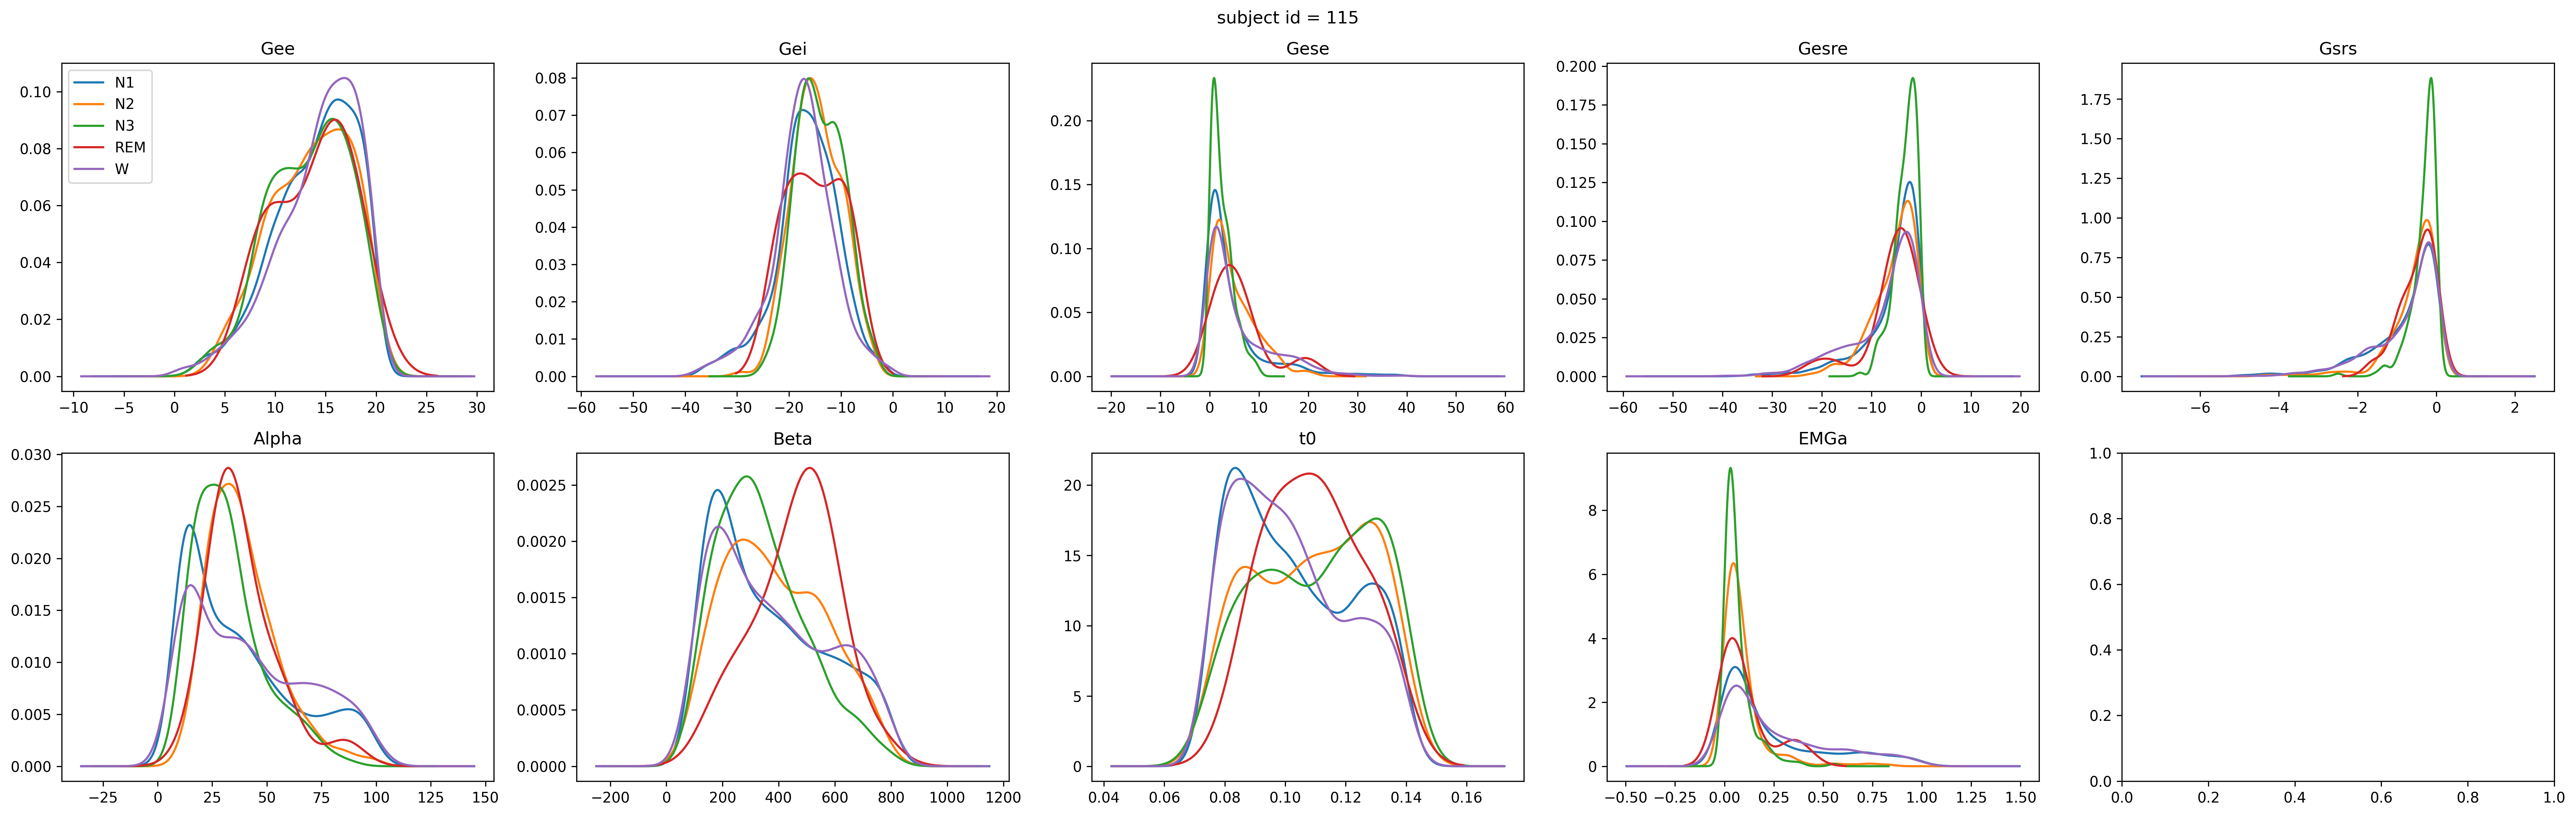

In [ ]:
fig,axes=plt.subplots(figsize=[25,8], ncols=int(np.ceil(len(param_names)/2)), nrows=2, dpi=300)
for m in sids[107:108]:
    for stage in stages:
        for i, param in enumerate(param_names):
            ax = axes.ravel()[i]
            sm=np.array(stages_ind.loc[m].dropna()==stage)
            m_df=all_res_df.loc[m].loc['fitted_params'].dropna(axis=1).T
            m_df[sm][param].plot(kind='kde', ax=ax)
            ax.set(title=param, ylabel="")
fig.suptitle("subject id = "+str(m))
lines=axes[0,0].get_lines()
axes[0,0].legend(lines, stages, loc='upper left')
plt.tight_layout()
plt.show()

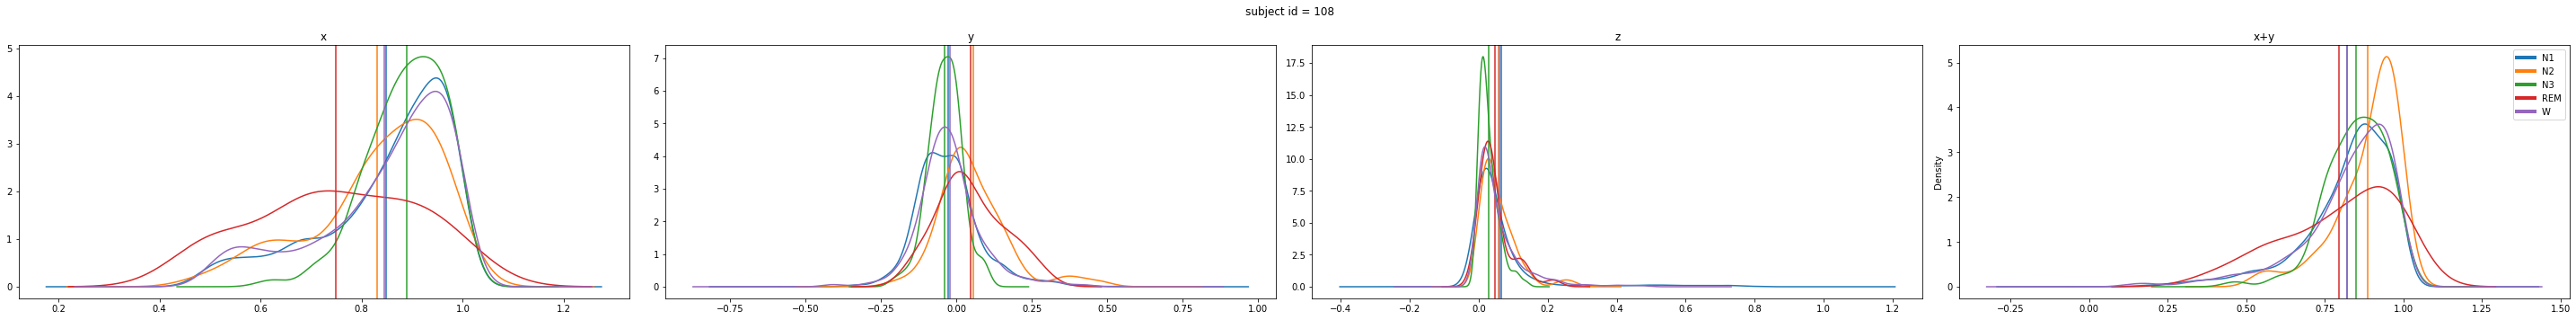

In [ ]:
colors=sns.color_palette()[0:(len(stages))]
lines= [Line2D([0], [0], color=clr, lw=4) for clr in colors]

for m in sids[100:101]:
    fig,axes=plt.subplots(figsize=[40,5], ncols=4)
    for stn, stage in enumerate((stages)):
        for i, param in enumerate(['x','y','z']):
            ax = axes.ravel()[i]
            sm=np.array(stages_ind.loc[m].dropna()==stage)
            b=all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm][param]
            b.plot(kind='kde', ax=ax, color=cols[stn])
            ax.axvline(x=b.mean(), color=cols[stn])
            ax.set(title=param, ylabel="")
        xy = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm]['x']+all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm]['y']
        xy.plot(kind='kde', ax=axes[-1])
        axes[-1].set(title='x+y')
        axes[-1].axvline(x=xy.mean(), color=cols[stn])
    fig.suptitle("subject id = "+str(m))
    plt.legend(lines, stages)
    plt.tight_layout()
    plt.show()

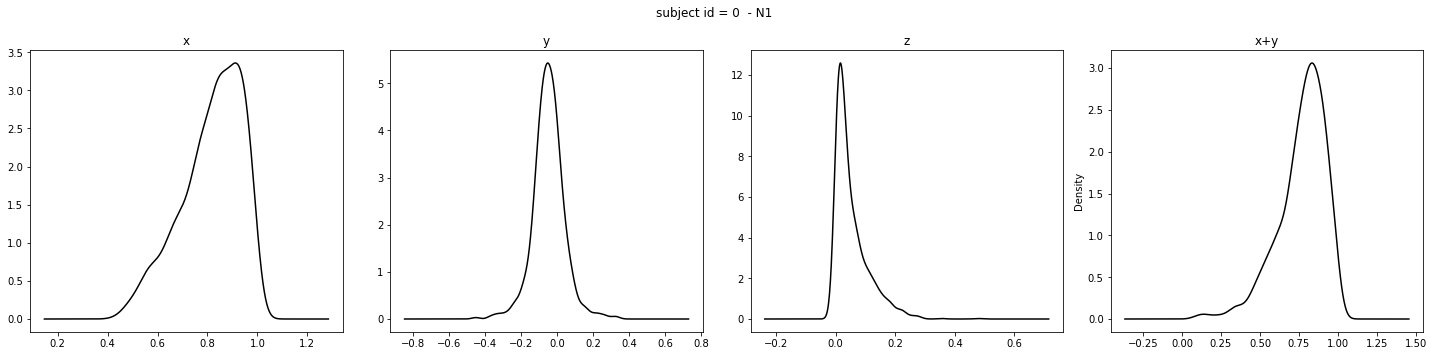

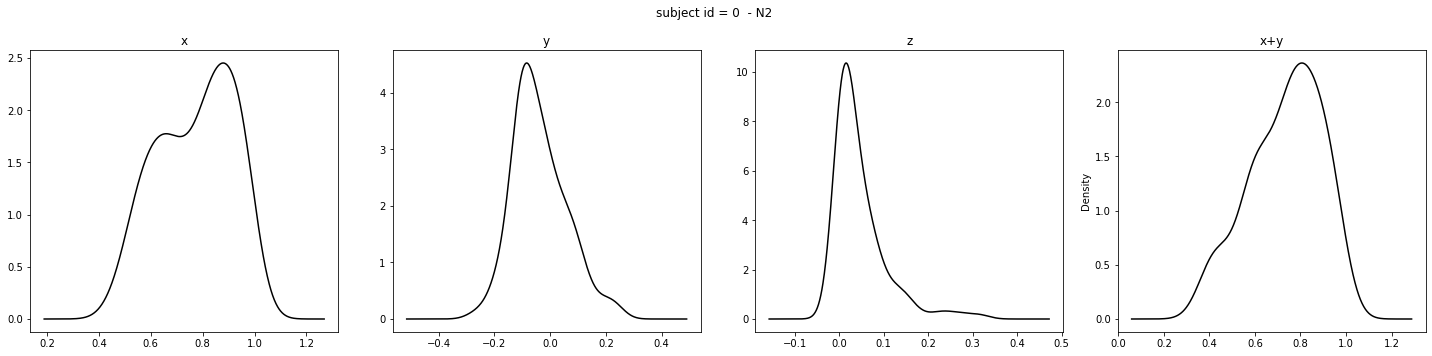

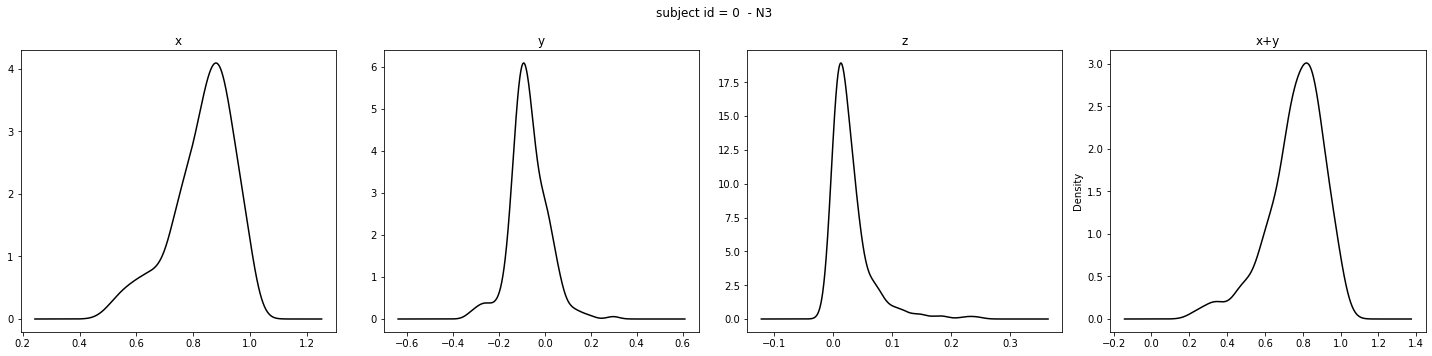

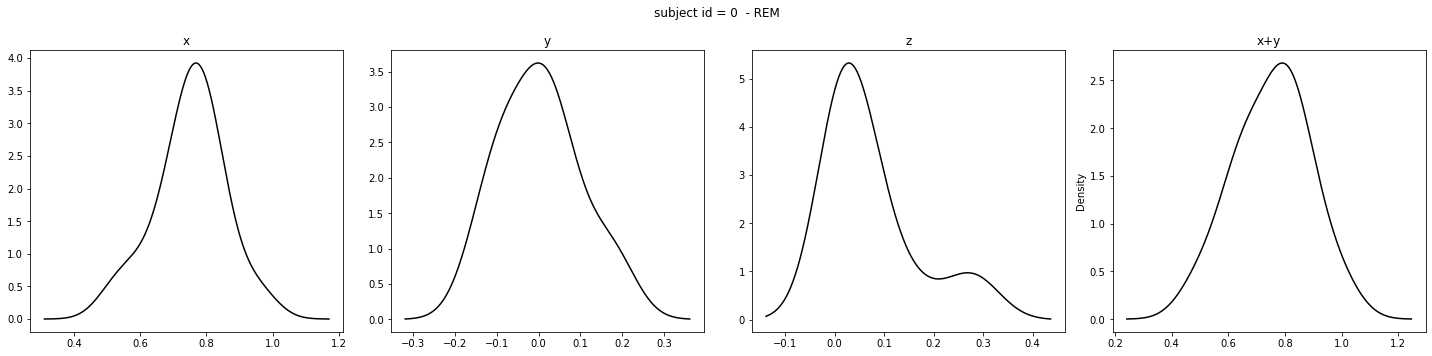

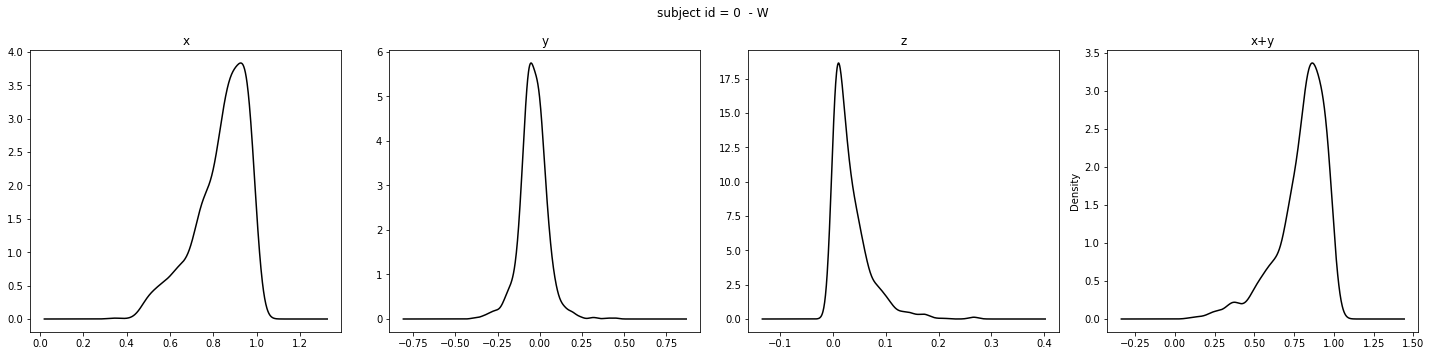

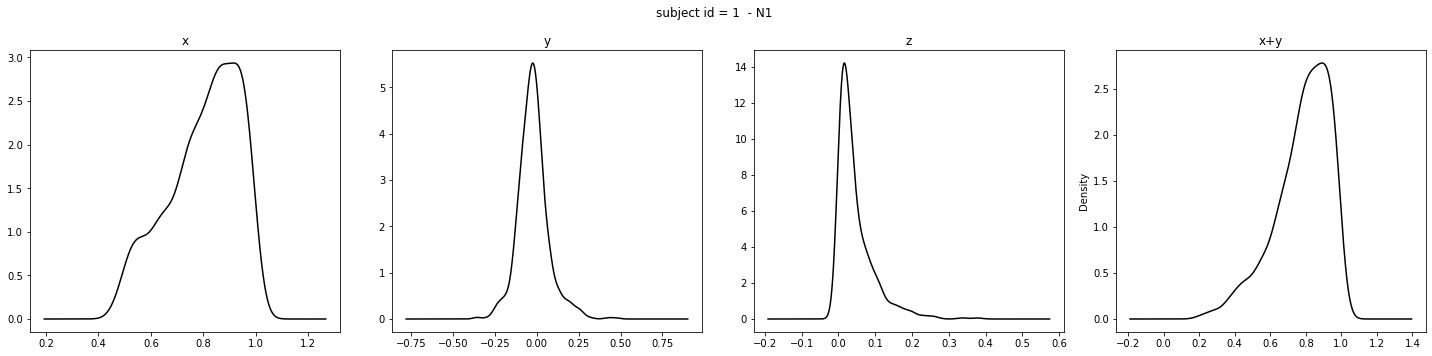

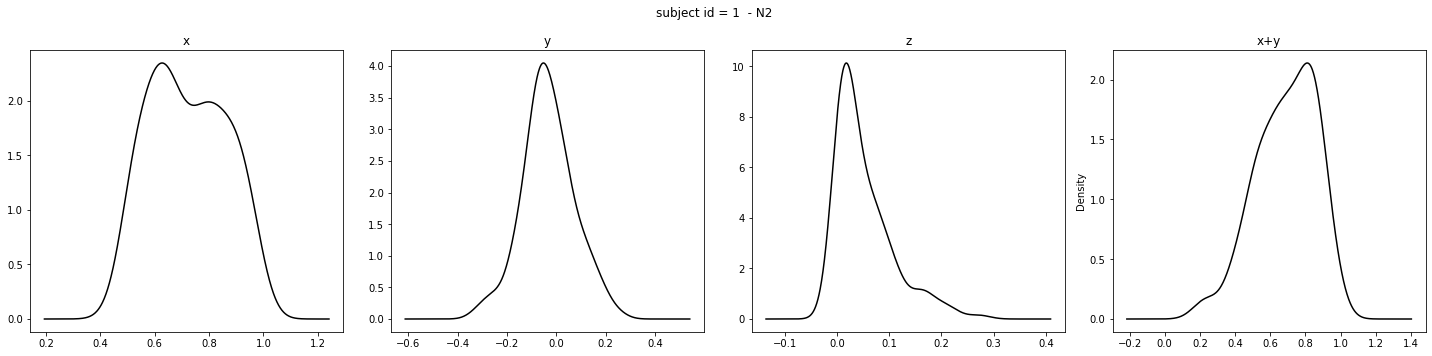

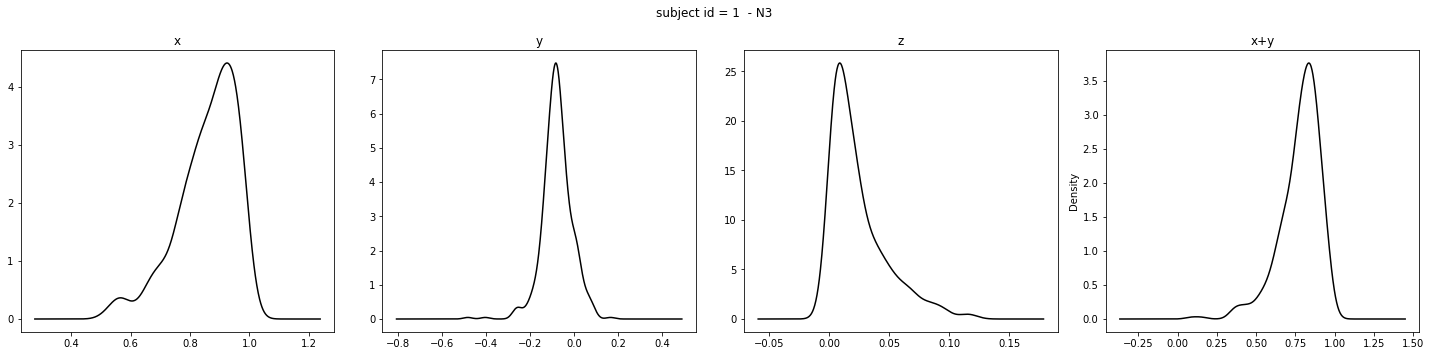

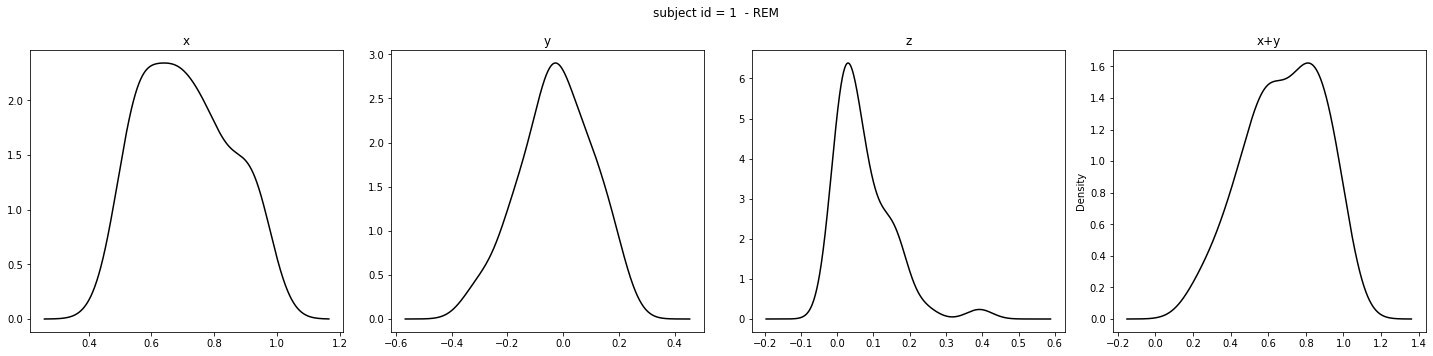

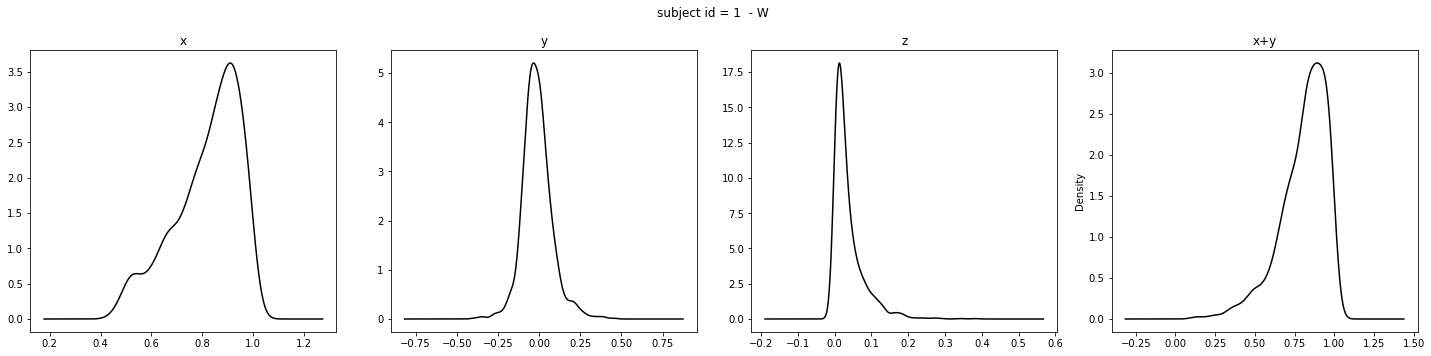

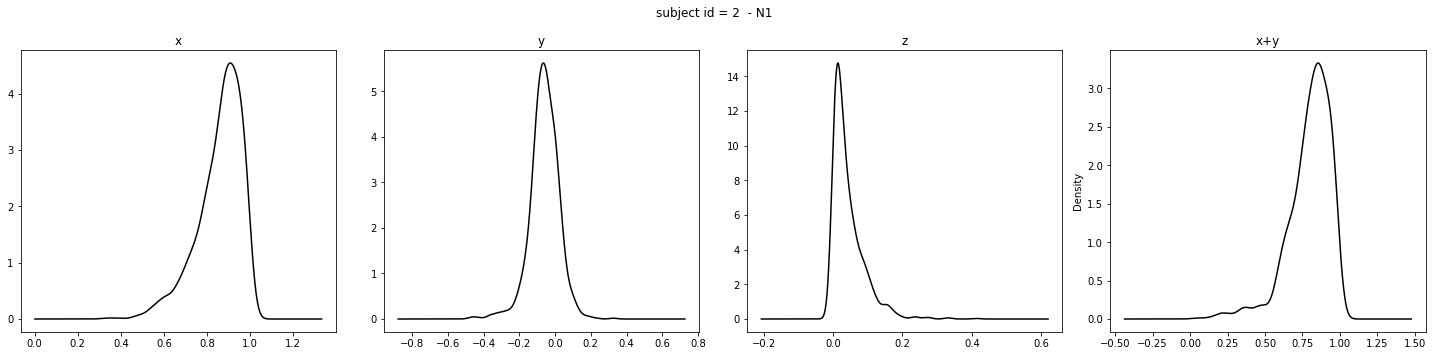

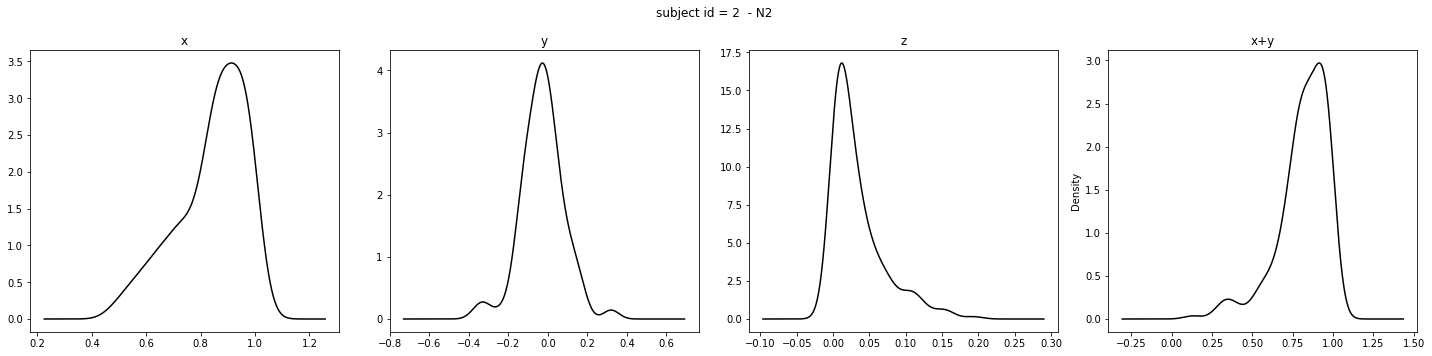

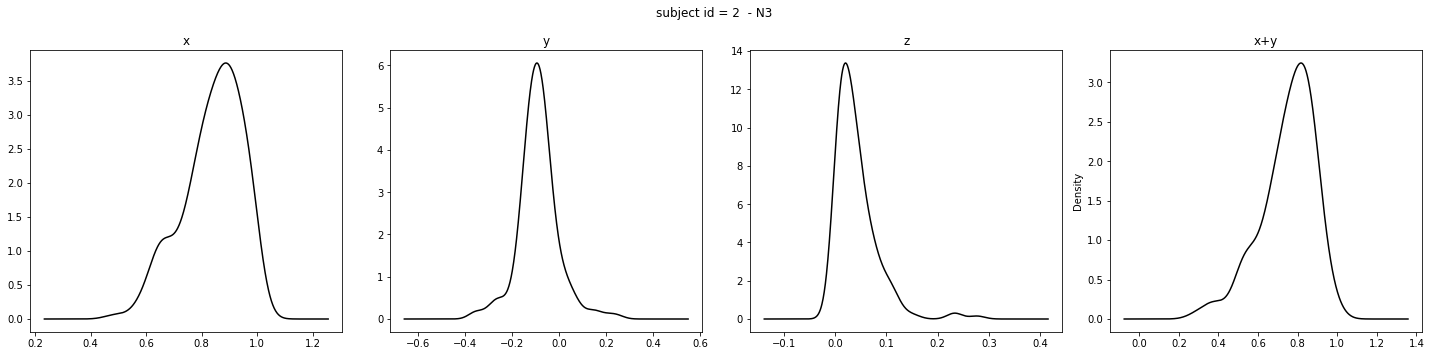

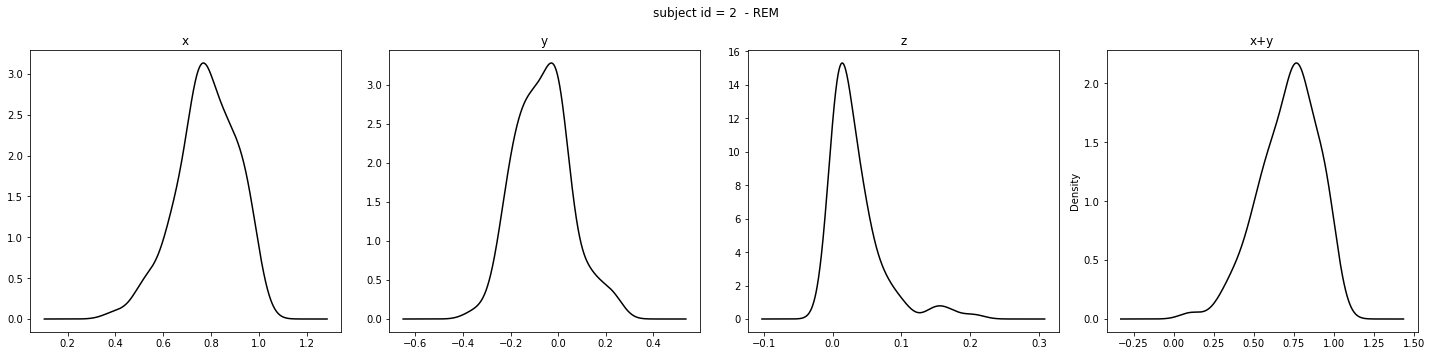

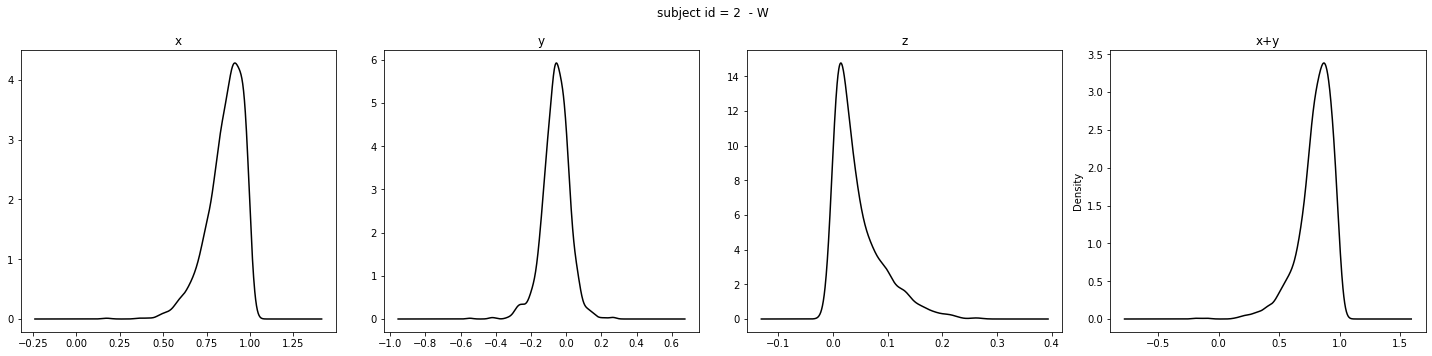

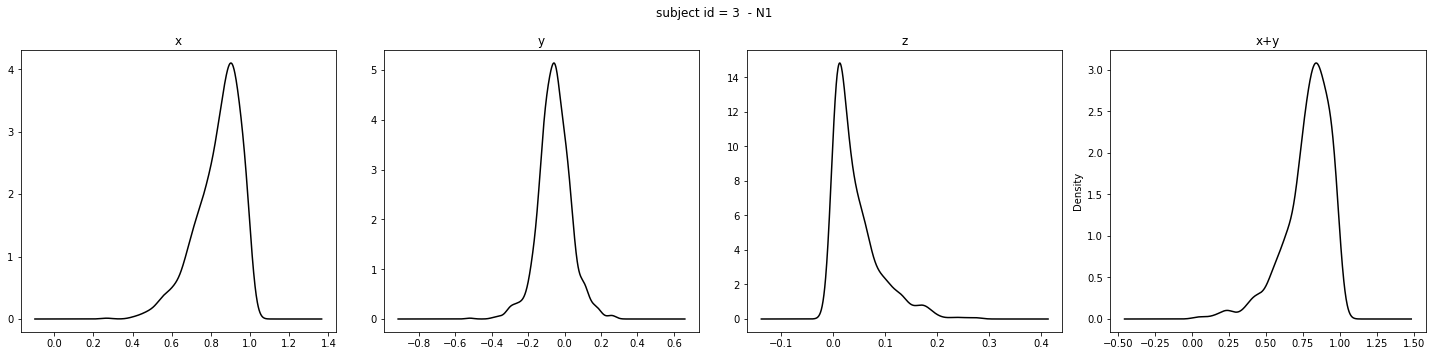

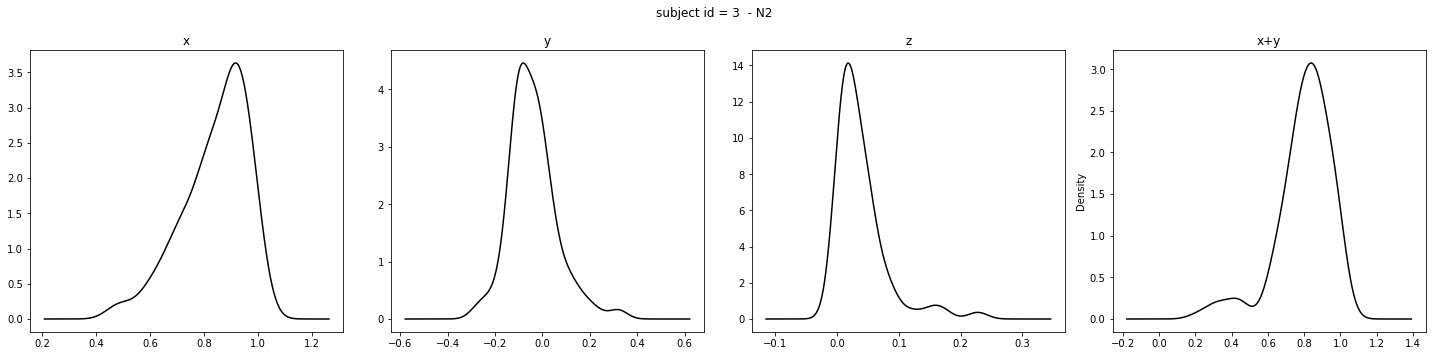

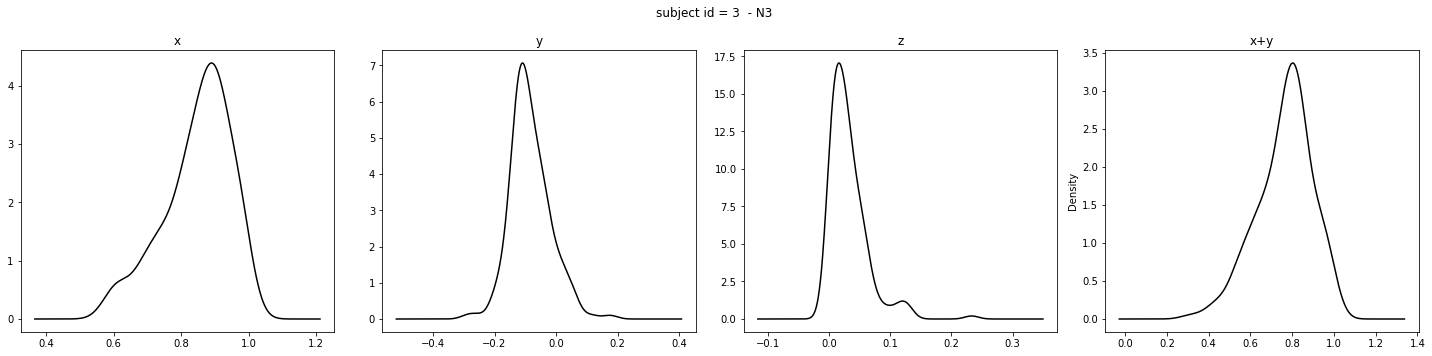

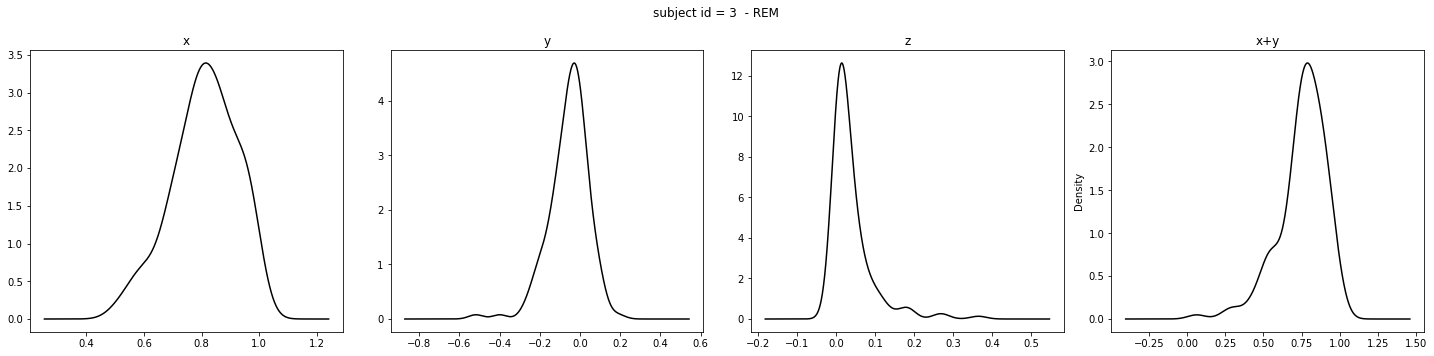

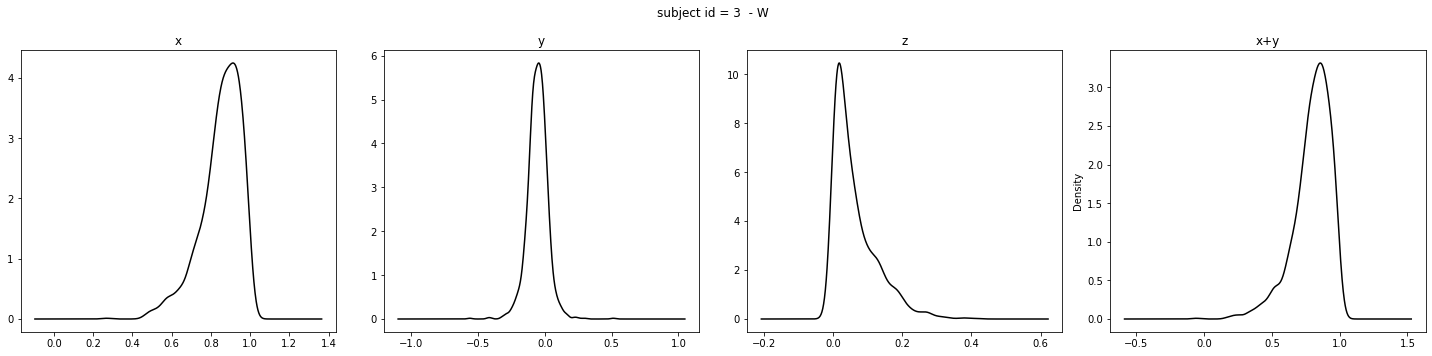

In [ ]:
for m in sids[0:4]:
    for stage in stages:
        fig,axes=plt.subplots(figsize=[20,5], ncols=4)
        for i, param in enumerate(['x','y','z']):
            ax = axes.ravel()[i]
            sm=np.array(stages_ind.loc[m].dropna()==stage)
            b=all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm][param]
            b.plot(kind='kde', ax=ax, color='k')
            ax.set(title=param, ylabel="")
        xy = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm]['x']+all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[sm]['y']
        xy.plot(kind='kde', ax=axes[-1], color='k')
        axes[-1].set(title='x+y')
        fig.suptitle("subject id = "+str(m)+"  - "+stage)
        # lines=axes[0].get_lines()
        # plt.legend(lines, stages)
        plt.tight_layout()
        plt.show()

### Example of the params' distribution across sleep stages:

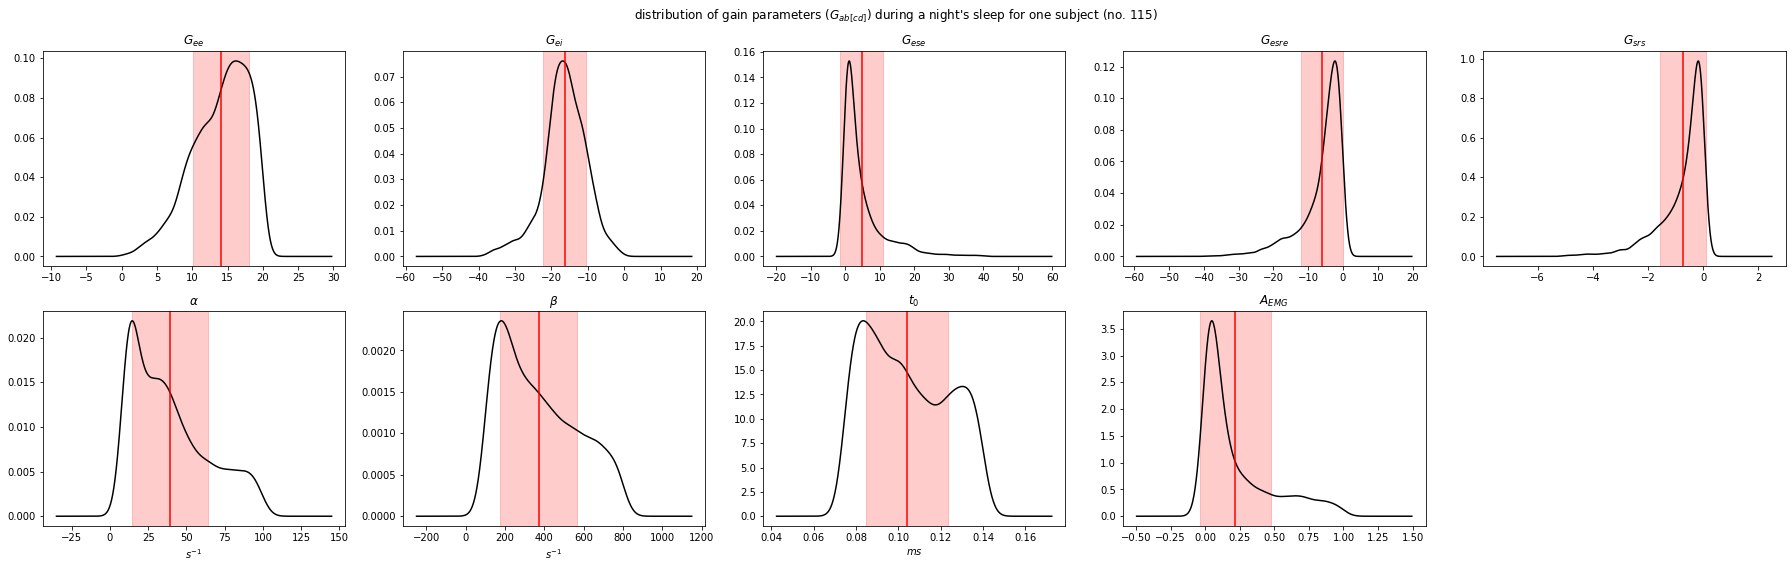

In [ ]:
for sub in sids[107:108]:
    fig,axes=plt.subplots(figsize=[25,8], ncols=int(np.ceil(len(param_names)/2)), nrows=2)
    for i, param in enumerate(param_names):
        ax = axes.ravel()[i]
        b=a[param][sub]
        bmean=b.mean()
        bstd=b.std()
        b.plot(kind='kde', ax=ax, color='black')
        ax.set(title=param_symbols[i],
               xlabel=param_units[i],
               ylabel="")
        ax.axvline(bmean, color='red')
        ax.axvspan(bmean-bstd, bmean+bstd, alpha=0.2, color='red')
    # axes.labelsize(25)
    axes.ravel()[-1].axis('off')
    fig.suptitle(r"distribution of gain parameters ($G_{ab[cd]}$) during a night's sleep for one subject (no. "+str(sub)+")")#, size=20, fontname='Nimbus Sans')
    plt.tight_layout()
    plt.show()

#### For all stages:

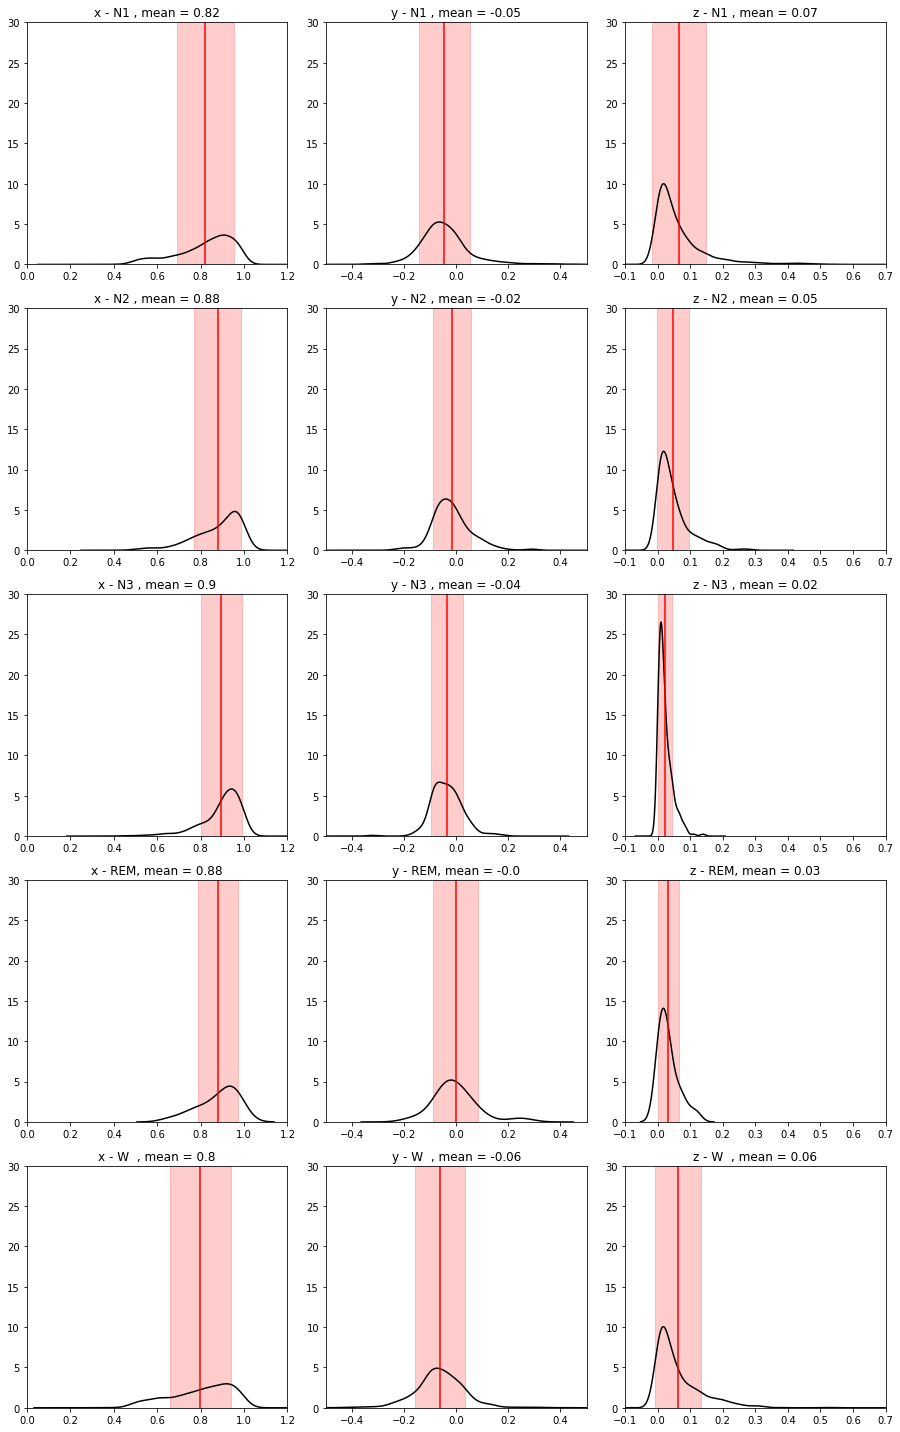

In [ ]:
for sub in sids[107:108]:
    fig,axes=plt.subplots(figsize=[12.5,20], ncols=3, nrows=len(stages))#, dpi=150)
    for stn, stage in enumerate(stages):
        for i, param in enumerate(['x','y','z']):
            sm=np.array(stages_ind.loc[sub].dropna()==stage)
            ax = axes[stn,i]
            b=all_res_df.loc[sub].loc['xyz'].dropna(axis=1).T[sm][param]
            bmean=b.mean()
            bstd=b.std()
            # ax.hist(b, color='black')
            b.plot(kind='kde', ax=ax, color='black')
            ax.set(title=param+ " - "+stage+", mean = "+str(round(bmean, 2)), ylabel="")
            ax.axvline(bmean, color='red')
            ax.axvspan(bmean-bstd, bmean+bstd, alpha=0.2, color='red')
    [ax.set_xlim(0,1.2) for ax in axes[:,0]] # x
    [ax.set_xlim(-0.5,0.5) for ax in axes[:,1]]
    [ax.set_xlim(-0.1,0.7) for ax in axes[:,2]]
    [ax.set_ylim(0,30) for ax in axes.ravel()]  
    # axes.labelsize(25)
    # fig.suptitle(r"distribution of xyz during a night's sleep for one subject (no. "+str(sub)+")") # It's subject 115. Removed so that we can put it on on PowerPoint
    plt.tight_layout()
    plt.show()

_________________________________

### Let's see how they correlate to each other

In [ ]:
a.T.swaplevel(0,1)

t                0           1           2           3           4     \
sid att                                                                 
0   Gee      9.142646   10.253498   16.074302   10.591239   13.164228   
    Gei     -9.369755  -12.766488  -15.541997  -12.660581  -18.838423   
    Gese     2.898020    1.163478    0.543142   13.315317   15.030426   
    Gesre   -0.978698   -3.416458   -1.668264  -15.999903  -21.412137   
    Gsrs    -2.516895   -0.408488   -0.264364   -0.162298   -0.379724   
...               ...         ...         ...         ...         ...   
147 Gsrs    -0.107772   -0.780075   -0.689143   -0.284155   -0.280367   
    Alpha   21.187881   11.205297   37.135783   14.434545   17.343509   
    Beta   235.272324  169.064566  666.428967  196.479889  297.855787   
    t0       0.125725    0.118953    0.090549    0.126283    0.137496   
    EMGa     0.255500    0.023225    0.201287    0.444443    0.145067   

t                5           6           7           8           9     ...  \
sid att                                                                ...   
0   Gee      5.512051   13.476423    2.234291   14.660319    7.301859  ...   
    Gei     -6.214326  -14.070595   -2.046453  -19.208322   -7.835259  ...   
    Gese     1.796261    2.806595    0.777080    1.822285    0.011431  ...   
    Gesre   -2.962598   -4.100500   -1.700133   -4.313694   -0.493804  ...   
    Gsrs    -0.943144   -0.069432   -1.299479   -1.535490   -0.396282  ...   
...               ...         ...         ...         ...         ...  ...   
147 Gsrs    -1.696378   -0.099435   -1.346141   -0.280349   -0.073972  ...   
    Alpha   12.534942   26.971151   23.995048   15.436055   89.067329  ...   
    Beta   122.085623  501.151326  342.886174  197.343638  350.572203  ...   
    t0       0.120563    0.102457    0.125385    0.117733    0.137685  ...   
    EMGa     0.017085    0.259419    0.144691    0.308779    0.227491  ...   

t          2869  2870  2871  2872  2873  2874  2875  2876  2877  2878  
sid att                                                                
0   Gee     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Gei     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Gese    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Gesre   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Gsrs    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
147 Gsrs    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Alpha   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    Beta    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    t0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
    EMGa    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1161 rows x 2879 columns]

#### Added solve to string issue:
Some of the MNE-exported have been having extra space tails. To remove that, we have used the function `spectra_stages()` which has been defined up the top of the doc. Using `spectra_stages(df_stages)` gives you the stages for that subject with a similar dimension

____________________________________________________________________________________________

#### Question: Is x+y anticorrelated to z?
Let's see across stages

In [ ]:
corrs={}
pvals={}
for stage in stages:
    x=all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['x']
    y = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['y']
    z = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['z']
    xy = x+y
    corrs[stage], pvals[stage] =st.pearsonr(np.array(xy),np.array(z))

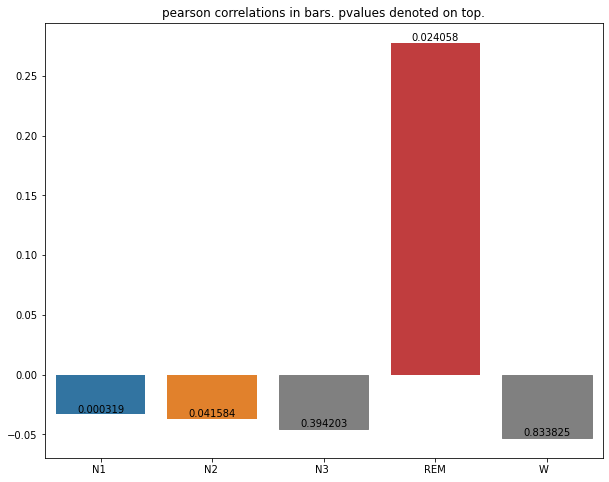

In [ ]:
plt.figure(figsize=(10,8))
ax=sns.barplot(y=list(corrs.values()), x=stages)

rects=ax.patches
for rect, pval in zip(rects, pvals.values()):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, np.round(pval,6), ha="center", va="bottom"
    )

for i,bar in enumerate(ax.patches):
    if list(pvals.values())[i] > 0.05:
        bar.set_color('grey')

ax.set(title='pearson correlations in bars. pvalues denoted on top.')
plt.show()

### Let's do the same thing in a population now:

In [ ]:
c={}
p={}
for m in tqdm(sids):
    corrs={}
    pvals={}
    for stage in stages:
        x=all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['x']
        y = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['y']
        z = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['z']
        xy = x+y
        corrs[stage], pvals[stage] =st.pearsonr(np.array(xy),np.array(z))
    c[m]=corrs
    p[m]=pvals

  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
xy_rs= pd.concat([
    pd.DataFrame(
        [cval for stage, cval in c[m].items()],
        index=stages, columns=['r'])
    for m in sids],
    keys=sids)

xy_ps= pd.concat([
    pd.DataFrame(
        [pval for stage, pval in p[m].items()],
        index=stages, columns=['p'])
    for m in sids],
    keys=sids)

In [ ]:
sigs=xy_ps<0.05
sigs=sigs.unstack(1)
sigs=sigs.T.loc['p']

Let's see how many of all stages had significant correlation:

In [ ]:
for i in range(len(stages)):
    l=sigs.iloc[i].value_counts()
    print(l, "\n")

True     85
False    44
Name: N1 , dtype: int64 

False    93
True     36
Name: N2 , dtype: int64 

False    108
True      21
Name: N3 , dtype: int64 

False    103
True      26
Name: REM, dtype: int64 

True     71
False    58
Name: W  , dtype: int64 



In [ ]:
sig_counts=pd.concat([sigs.iloc[i].value_counts() for i in range(len(stages))], keys=stages)

In [ ]:
sig_counts

N1   True      85
     False     44
N2   False     93
     True      36
N3   False    108
     True      21
REM  False    103
     True      26
W    True      71
     False     58
dtype: int64

### let's see the significant correlation across different stages:

In [ ]:
xy_r= pd.concat([
    pd.DataFrame(
        [cval for stage, cval in c[m].items()],
        index=stages)
    for m in sids],
    keys=sids)

xy_p= pd.concat([
    pd.DataFrame(
        [pval for stage, pval in p[m].items()],
        index=stages)
    for m in sids],
    keys=sids)

In [ ]:
xy_r[xy_p<0.05]

0
0   N1  -0.073970
    N2        NaN
    N3        NaN
    REM       NaN
    W   -0.104322
...           ...
147 N1   0.092299
    N2   0.185556
    N3        NaN
    REM  0.197076
    W         NaN

[645 rows x 1 columns]

In [ ]:
xy_r.loc[0].loc['N1 ']

0   -0.07397
Name: N1 , dtype: float64

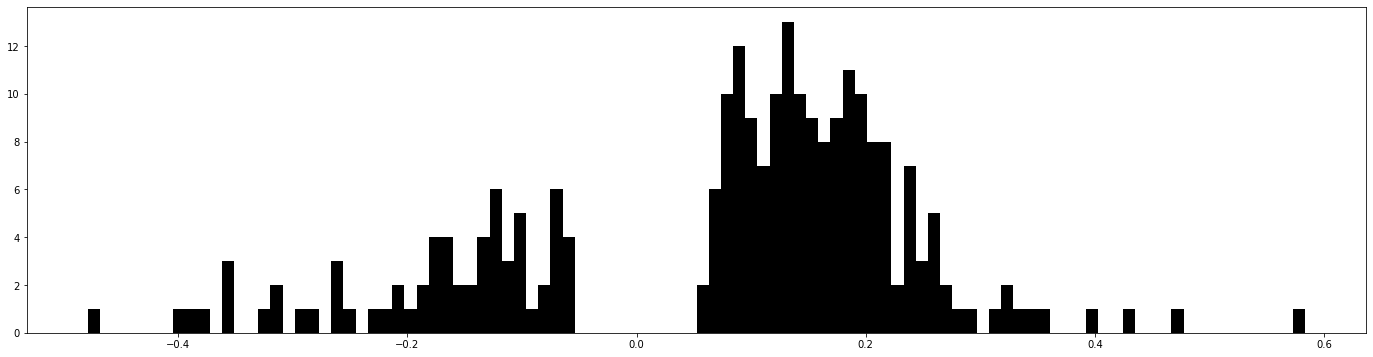

In [ ]:
plt.figure(figsize=figsize); plt.hist(xy_r[xy_p<0.05], bins=100, color='black'); plt.show()
# .plot(kind='hist', legend=False, title='r values across significant correlations', figsize=(30,6), );

### The r-values for significantly-correlations of `x+y` vs `z`

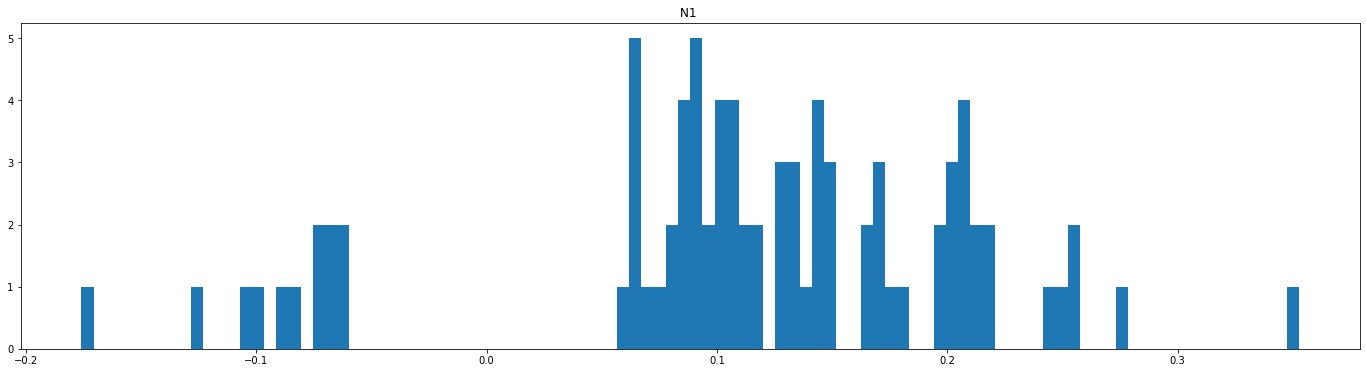

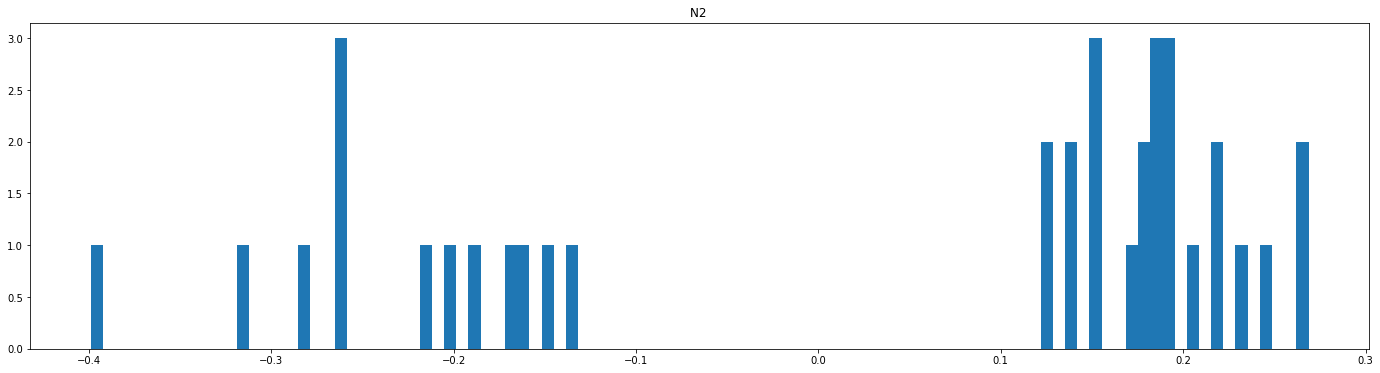

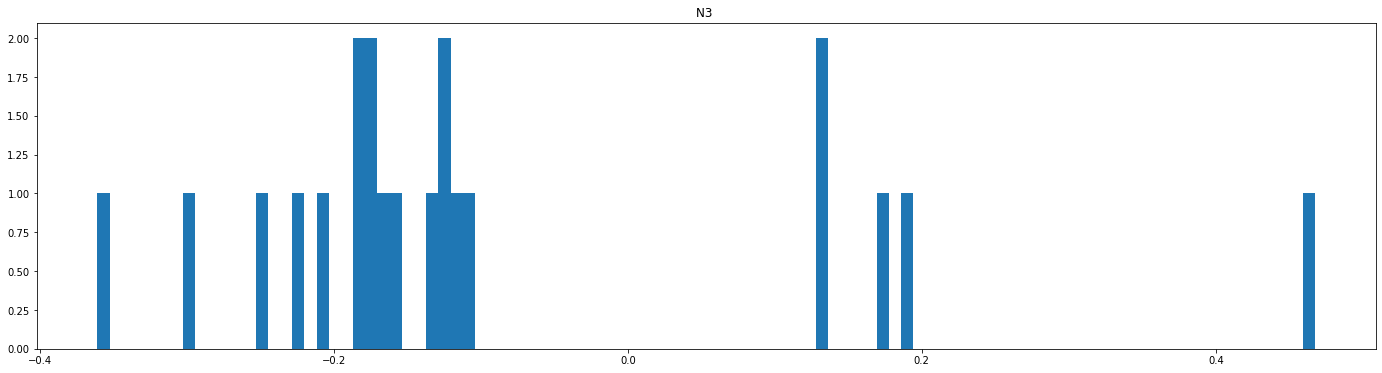

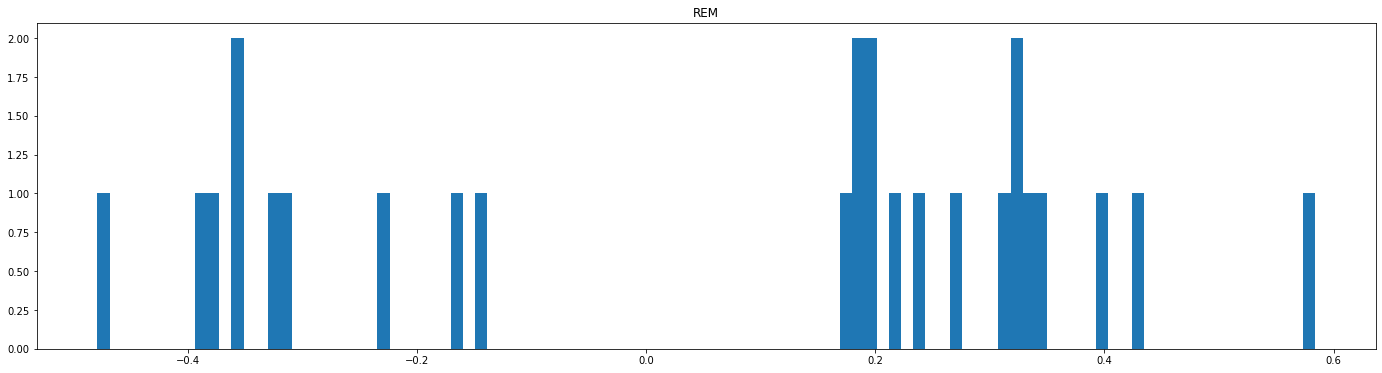

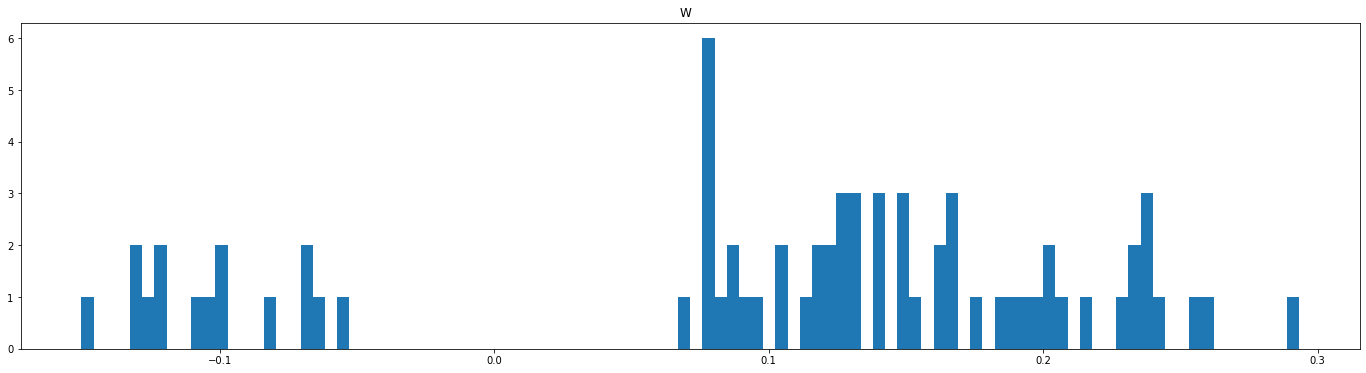

In [ ]:
for i, stage in enumerate(list(xy_r[xy_p<0.05].unstack(0).index)):
    plt.figure(figsize=figsize); ax=plt.hist(xy_r[xy_p<0.05].unstack(0).iloc[i], bins=100); plt.title(stage); plt.show()
    # .plot(kind='kde', legend=True, title='r values across significant correlations in different sleep stages', figsize=(30,6));

In [ ]:
xy_r[xy_p<0.05].unstack(0).iloc[i]

0  0     -0.104322
   1           NaN
   2           NaN
   3           NaN
   4     -0.131095
            ...   
   143         NaN
   144    0.079917
   145    0.078970
   146    0.078609
   147         NaN
Name: W  , Length: 129, dtype: float64

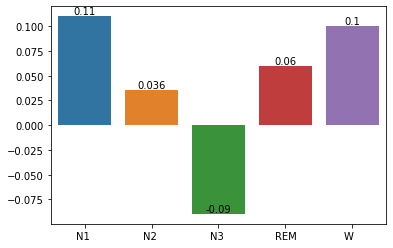

In [ ]:
ax=sns.barplot(x=stages, y=[xy_r[xy_p<0.05].unstack(0).iloc[i].mean() for i, stage in enumerate(list(xy_r[xy_p>0.05].unstack(0).index))])
rects=ax.patches
for rect, pval in zip(rects, [xy_r[xy_p<0.05].unstack(0).iloc[i].mean() for i, stage in enumerate(list(xy_r[xy_p>0.05].unstack(0).index))]):
    height = rect.get_height()
    ax.text(
        (rect.get_x() + rect.get_width() / 2), height, str(np.round(pval,3)), ha="center", va="bottom"
    )

### **Interpretation of above**: 
We only see significant anticorrelation in `W`. In REM actually we see positive correlation. But all the r-values are too small

______________

#### Let's plot the one individual example:

In [ ]:
colors=sns.color_palette('colorblind', n_colors=10)
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [ ]:
stage_dict={'W':0,
            'REM':1,
            'N1':2,
            'N2':3,
            'N3':4
            }

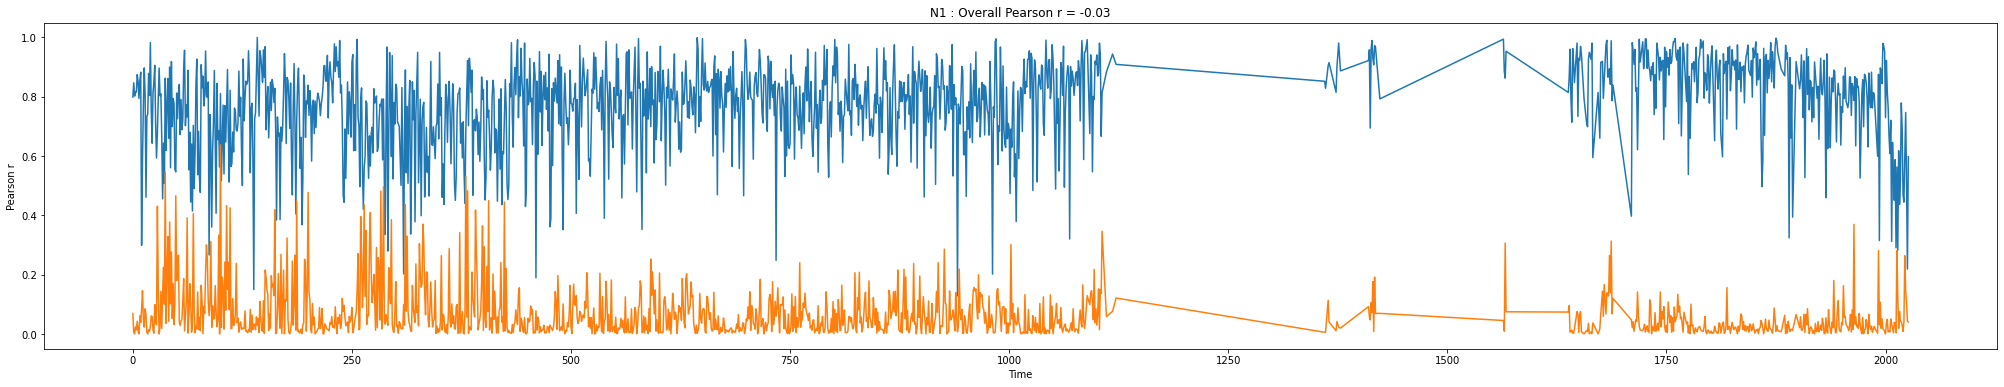

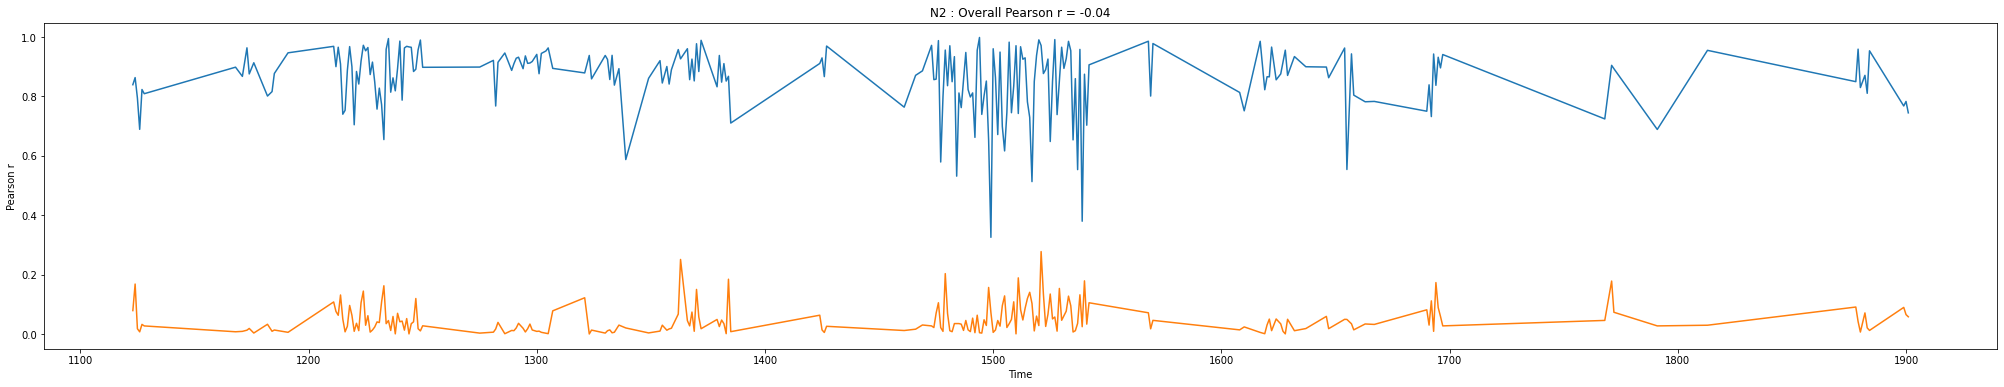

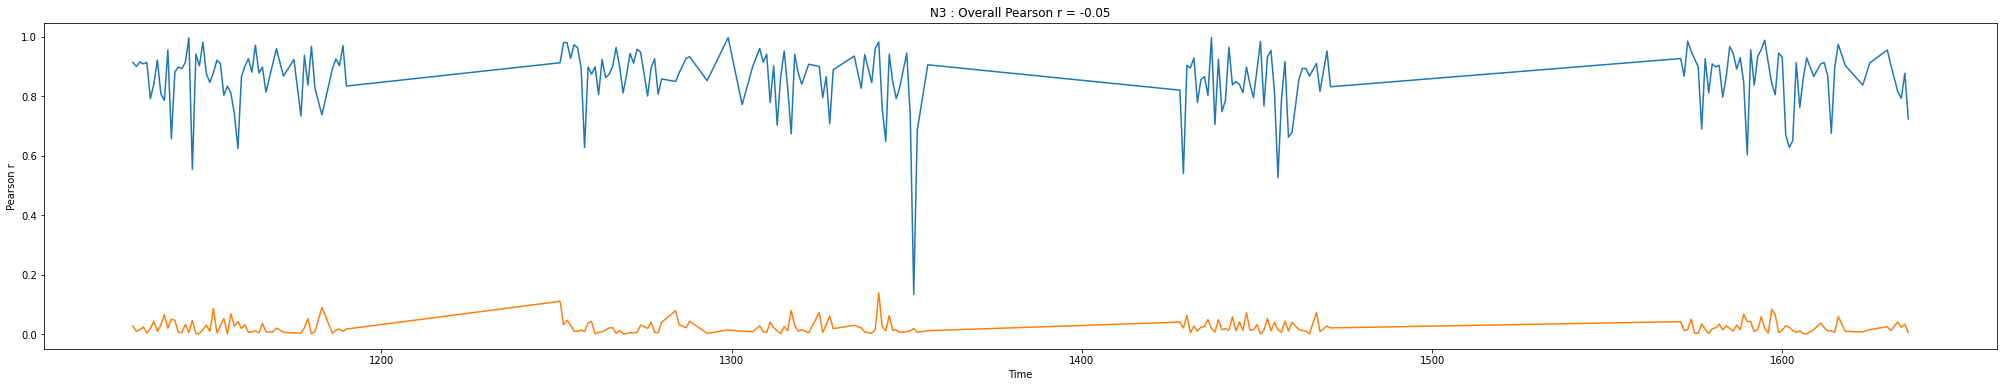

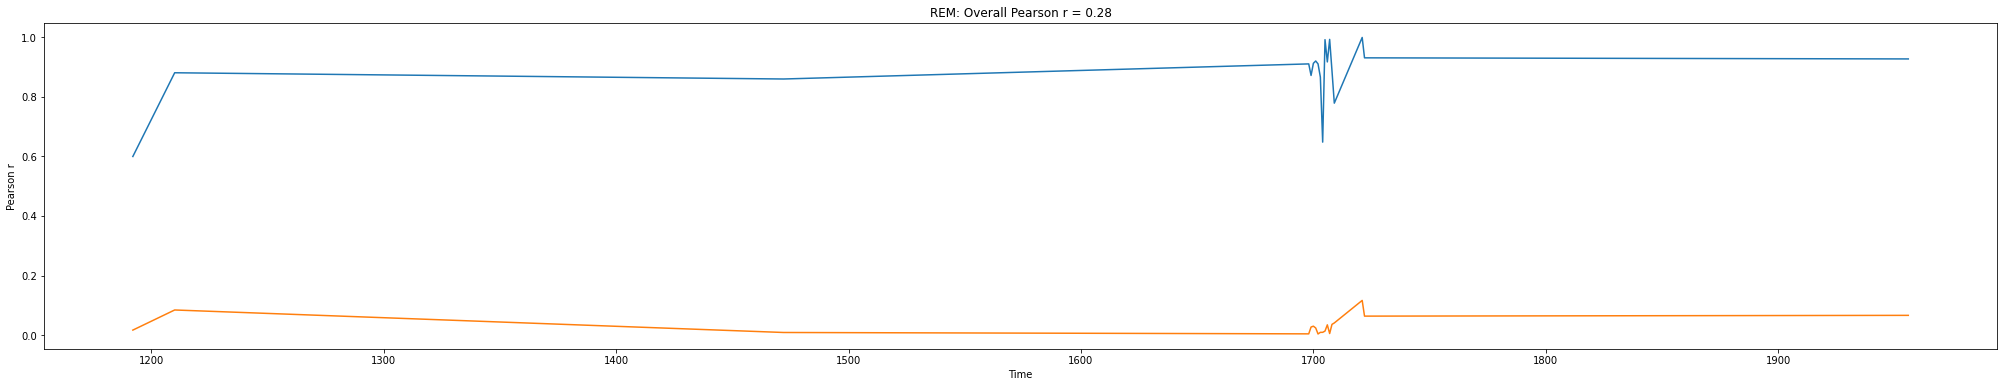

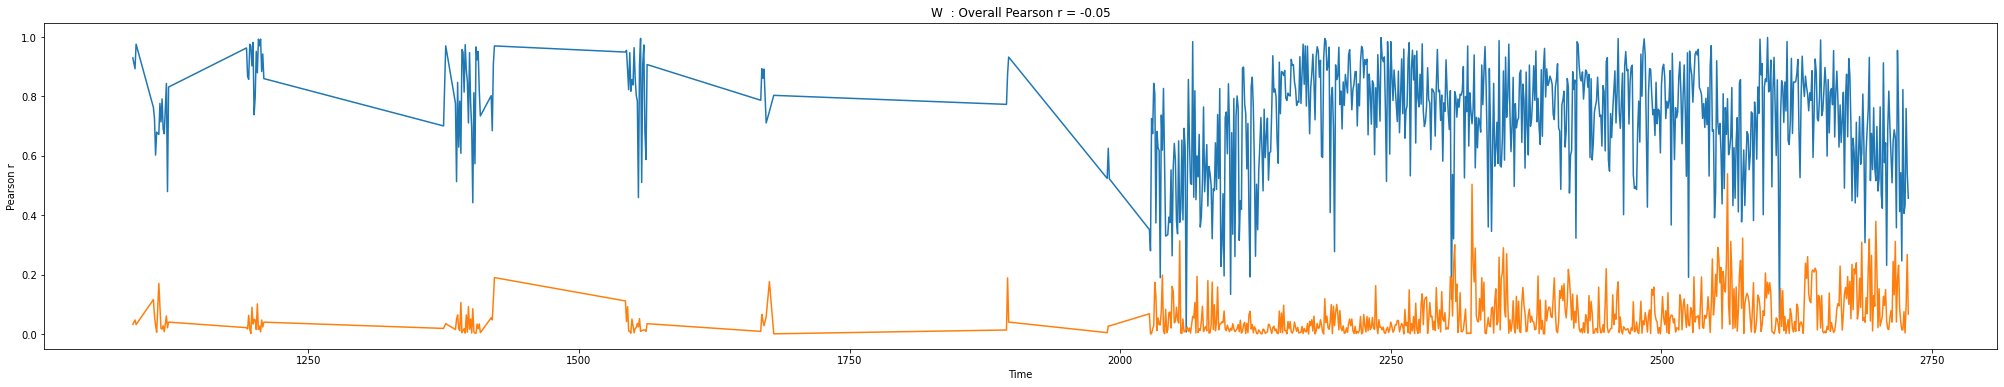

In [ ]:
corrs={}
for stage in stages:
    x=all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['x']
    y = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['y']
    z = all_res_df.loc[m].loc['xyz'].dropna(axis=1).T[np.array(stages_ind.loc[m].dropna()==stage)]['z']
    xy = x+y
    corr, _ =st.pearsonr(np.array(xy),np.array(z))
    corrs[stage]=corr
    
    fig,ax=plt.subplots(figsize=(35,6))
    xy.plot(ax=ax)
    z.plot(ax=ax)
    ax.set(xlabel='Time',ylabel='Pearson r')
    ax.set(title=stage+ f": Overall Pearson r = {np.round(corr,2)}");

In [ ]:
corrs

{'N1 ': -0.033208653289567035,
 'N2 ': -0.03683115951111396,
 'N3 ': -0.0455327791970238,
 'REM': 0.2777519782725776,
 'W  ': -0.05308016301300671}

In [ ]:
a

att         Gee        Gei       Gese      Gesre      Gsrs      Alpha  \
sid         0          0          0          0         0          0     
t                                                                       
0      9.142646  -9.369755   2.898020  -0.978698 -2.516895  10.440872   
1     10.253498 -12.766488   1.163478  -3.416458 -0.408488  22.682659   
2     16.074302 -15.541997   0.543142  -1.668264 -0.264364  46.890180   
3     10.591239 -12.660581  13.315317 -15.999903 -0.162298  70.185369   
4     13.164228 -18.838423  15.030426 -21.412137 -0.379724  38.060016   
...         ...        ...        ...        ...       ...        ...   
2874        NaN        NaN        NaN        NaN       NaN        NaN   
2875        NaN        NaN        NaN        NaN       NaN        NaN   
2876        NaN        NaN        NaN        NaN       NaN        NaN   
2877        NaN        NaN        NaN        NaN       NaN        NaN   
2878        NaN        NaN        NaN        NaN       NaN        NaN   

att         Beta        t0      EMGa        Gee  ...      EMGa        Gee  \
sid          0         0         0          1    ...       146        147   
t                                                ...                        
0     119.149649  0.078498  0.028818  16.766792  ...  0.258866  11.642220   
1     117.908474  0.120484  0.121047  12.653331  ...  0.103917  11.722108   
2     494.465389  0.082200  0.162980  19.068928  ...  0.031824  14.489391   
3     193.308939  0.096237  0.417115  16.012505  ...  0.019420  11.206219   
4     386.936369  0.102390  0.040636  13.929109  ...  0.322879  12.108311   
...          ...       ...       ...        ...  ...       ...        ...   
2874         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2875         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2876         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2877         NaN       NaN       NaN        NaN  ...       NaN        NaN   
2878         NaN       NaN       NaN        NaN  ...       NaN        NaN   

att         Gei      Gese     Gesre      Gsrs      Alpha        Beta  \
sid         147       147       147       147        147         147   
t                                                                      
0    -15.107260  5.252564 -5.245046 -0.107772  21.187881  235.272324   
1    -16.004658  3.968242 -5.925015 -0.780075  11.205297  169.064566   
2    -15.652338  7.413098 -9.402922 -0.689143  37.135783  666.428967   
3    -10.479963  1.821624 -1.594866 -0.284155  14.434545  196.479889   
4    -13.299711  5.467019 -5.090138 -0.280367  17.343509  297.855787   
...         ...       ...       ...       ...        ...         ...   
2874        NaN       NaN       NaN       NaN        NaN         NaN   
2875        NaN       NaN       NaN       NaN        NaN         NaN   
2876        NaN       NaN       NaN       NaN        NaN         NaN   
2877        NaN       NaN       NaN       NaN        NaN         NaN   
2878        NaN       NaN       NaN       NaN        NaN         NaN   

att         t0      EMGa  
sid        147       147  
t                         
0     0.125725  0.255500  
1     0.118953  0.023225  
2     0.090549  0.201287  
3     0.126283  0.444443  
4     0.137496  0.145067  
...        ...       ...  
2874       NaN       NaN  
2875       NaN       NaN  
2876       NaN       NaN  
2877       NaN       NaN  
2878       NaN       NaN  

[2879 rows x 1161 columns]

____________________________

# Spectral analysis:

In [ ]:
for spectra_type in ['fitted_spectra', 'target_spectra']:
    myVars=vars()
    myVars.__setitem__('df_%s' % spectra_type, pd.concat(
                                                [(pd.concat([
                                                    (all_res_df.loc[sid,spectra_type,:].dropna(axis=1).reset_index(level=['sid', 'cat'], drop=True).T[all_res_stages.loc[sid]['state_str']==stage])
                                                    for stage in stages],
                                                    keys=stages))
                                                 for sid in tqdm(sids, desc=spectra_type)],
                                                keys=sids))

fitted_spectra:   0%|          | 0/129 [00:00<?, ?it/s]

target_spectra:   0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
# dfs1=df_fitted_spectra.swaplevel(0,1).reset_index(level=1, drop=True)

In [ ]:
dfs1=df_fitted_spectra.swaplevel(0,1)

In [ ]:
dfs1.loc['N1',:,:]

att          1.000000   1.333333   1.666667   2.000000   2.333333   2.666667   \
       t                                                                        
N1 0   0      0.619254   0.433567   0.338553   0.285496   0.251974   0.225680   
       1      0.325800   0.505336   0.589658   0.403928   0.236505   0.151139   
       2      0.961598   0.679338   0.448083   0.292007   0.194799   0.135080   
       3      0.081919   0.173575   0.815812   1.207962   0.160794   0.057156   
       4      0.070984   0.128759   0.364187   1.343501   0.336421   0.107268   
...                ...        ...        ...        ...        ...        ...   
   147 2140   0.428296   0.313771   0.214086   0.145024   0.101566   0.074784   
       2141   0.228940   0.376198   0.398986   0.228374   0.124071   0.078412   
       2142   0.311266   0.316477   0.308867   0.283235   0.242944   0.197920   
       2143   0.295393   0.403997   0.442537   0.315802   0.184210   0.111151   
       2144   0.464590   0.401390   0.305776   0.218755   0.157179   0.117673   

att          3.000000   3.333333   3.666667   4.000000   ...  37.000000  \
       t                                                 ...              
N1 0   0      0.200774   0.175359   0.148973   0.122159  ...   0.001193   
       1      0.108118   0.084786   0.071331   0.063204  ...   0.002469   
       2      0.097731   0.073647   0.057567   0.046452  ...   0.001691   
       3      0.029980   0.019044   0.013509   0.010347  ...   0.001593   
       4      0.053842   0.033882   0.024312   0.019127  ...   0.000909   
...                ...        ...        ...        ...  ...        ...   
   147 2140   0.058086   0.047464   0.040619   0.036250  ...   0.001192   
       2141   0.057189   0.046602   0.041451   0.039736  ...   0.001115   
       2142   0.157019   0.124104   0.099230   0.080920  ...   0.000486   
       2143   0.073781   0.053700   0.042220   0.035387  ...   0.001859   
       2144   0.092993   0.077742   0.068672   0.063988  ...   0.000901   

att          37.333333  37.666667  38.000000  38.333333  38.666667  39.000000  \
       t                                                                        
N1 0   0      0.001194   0.001196   0.001197   0.001198   0.001199   0.001199   
       1      0.002472   0.002474   0.002476   0.002478   0.002479   0.002480   
       2      0.001692   0.001692   0.001692   0.001692   0.001692   0.001691   
       3      0.001593   0.001593   0.001593   0.001593   0.001593   0.001593   
       4      0.000908   0.000908   0.000907   0.000907   0.000906   0.000906   
...                ...        ...        ...        ...        ...        ...   
   147 2140   0.001187   0.001181   0.001176   0.001171   0.001167   0.001162   
       2141   0.001114   0.001112   0.001111   0.001109   0.001108   0.001106   
       2142   0.000479   0.000472   0.000465   0.000459   0.000453   0.000447   
       2143   0.001851   0.001843   0.001836   0.001828   0.001821   0.001814   
       2144   0.000896   0.000892   0.000888   0.000884   0.000880   0.000877   

att          39.333333  39.666667  40.000000  
       t                                      
N1 0   0      0.001200   0.001200   0.001200  
       1      0.002481   0.002481   0.002481  
       2      0.001691   0.001690   0.001689  
       3      0.001593   0.001592   0.001592  
       4      0.000905   0.000904   0.000903  
...                ...        ...        ...  
   147 2140   0.001157   0.001152   0.001147  
       2141   0.001105   0.001103   0.001101  
       2142   0.000442   0.000436   0.000431  
       2143   0.001806   0.001797   0.001789  
       2144   0.000873   0.000869   0.000865  

[165947 rows x 118 columns]

In [ ]:
freqs=np.array(ps.index,dtype=float)

In [ ]:
freqs[(freqs>4) & (freqs<8)]

array([4.33333333, 4.66666667, 5.        , 5.33333333, 5.66666667,
       6.        , 6.33333333, 6.66666667, 7.        , 7.33333333,
       7.66666667])

In [ ]:
bands={'delta'  : [1,4]    ,
       'theta'  : [4,7.5]  ,
       'alpha'  : [7.5,13] ,
       'spindle': [11,16]  ,
       'beta'   : [13,30]  }

In [ ]:
for band, [low, high] in bands.items():
    print(band, low, high)

delta 1 4
theta 4 7.5
alpha 7.5 13
spindle 11 16
beta 13 30


Percentage of positive `y` values:
[*True* is positive and *False* is negative]

In [ ]:
for stage in stages:
    print(stage)
    df_here=pd.DataFrame(xyz1.loc[stage,:].reset_index(drop=True)['y']>0)
    print(len(df_here))
    print(df_here.value_counts(normalize=True)*100)
    print()

N1
165947
y    
False    70.882872
True     29.117128
dtype: float64

N2
25414
y    
False    68.115999
True     31.884001
dtype: float64

N3
28941
y    
False    84.392385
True     15.607615
dtype: float64

REM
10184
y    
False    69.157502
True     30.842498
dtype: float64

W
120855
y    
False    72.383435
True     27.616565
dtype: float64



### PSD analysis using FOOOF:
We'll use fooof to analyze the target and fitted power spectra

Let's see how we can use FOOOF:

In [ ]:
# fm1 = FOOOF(min_peak_height=0.1, verbose=False)
# fm1.fit(freqs,np.array(df_target_Ps[3]))
# fm1.plot(plot_peaks='shade',peak_kwargs={'color':'green'})

Now let's implement the fooof periodic peakfinder and apply it to all the sids:

In [ ]:
spectra_stages??

Signature: spectra_stages(df_epochs)
Docstring: <no docstring>
Source:   
def spectra_stages(df_epochs):
    for i,j in enumerate(df_epochs['state_str']):
        j=j.split(" ")[0]
        df_epochs.loc[i]=j
    return np.array(df_epochs['state_str'])
File:      /tmp/ipykernel_25234/3745087049.py
Type:      function


In [ ]:
dict_fooof_params={}
for i in tqdm(sids):
    dict_fooof_params[i]={}
    df_epochs=list(all_res[i])[9]
    eps=spectra_stages(df_epochs)
    stages = np.unique(eps)
    a={}
    for stage in stages:
        target_spectra=all_res_df.loc[i].loc['target_spectra'].dropna(axis=1, how='all').loc[:,eps==stage]
        fitted_spectra=all_res_df.loc[i].loc['fitted_spectra'].dropna(axis=1, how='all').loc[:,eps==stage]
        fmt = FOOOF(min_peak_height=0.05, verbose=False)
        fmt.fit(freqs,np.array(target_spectra.mean(axis=1)))
        fmf = FOOOF(min_peak_height=0.05, verbose=False)
        fmf.fit(freqs,np.array(fitted_spectra.mean(axis=1)))

        a[stage] = pd.concat([fooofpardf(fmt),fooofpardf(fmf)],keys=['target','fitted'])
        a[stage].index.names=[None,'cf']
    dict_fooof_params[i]=pd.concat([a[stage] for stage in a], keys=list(a.keys()), names=['stages'])
    
df_fooof_params=pd.concat([v for k,v in dict_fooof_params.items()], keys=sids, names=['sids'])

  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
df_fooof_params

amp         bw
sids stages        cf                            
0    N1     target 4.602713   0.654947   6.344444
            fitted 5.634690   0.653471   6.969279
     N2     target 5.673607   0.243100   3.122573
                   7.807715   0.576353   1.653474
                   21.784282  0.083853   4.281308
...                                ...        ...
147  W      target 9.368617   0.237021   1.729829
                   32.730621  0.138751  12.000000
            fitted 1.891521   0.298235   1.839779
                   8.027566   0.177578   2.331112
                   9.364166   0.354812   1.670288

[4017 rows x 2 columns]

Let's separate the missing stages across subs:

In [ ]:
fails=[]
success=pd.DataFrame()
success.index=pd.MultiIndex.from_product([sids, stages], names=['sid','stage'])
for sid in sids:
    for stage in stages:
        try:
            tars=df_fooof_params.loc[sid].loc[:].loc['target']
            success=tars
        except KeyError:
            fails.append({'sid':sid, 'stage':stage})

Now let's look at the **amplitude** and **centre frequency** across difference stages:

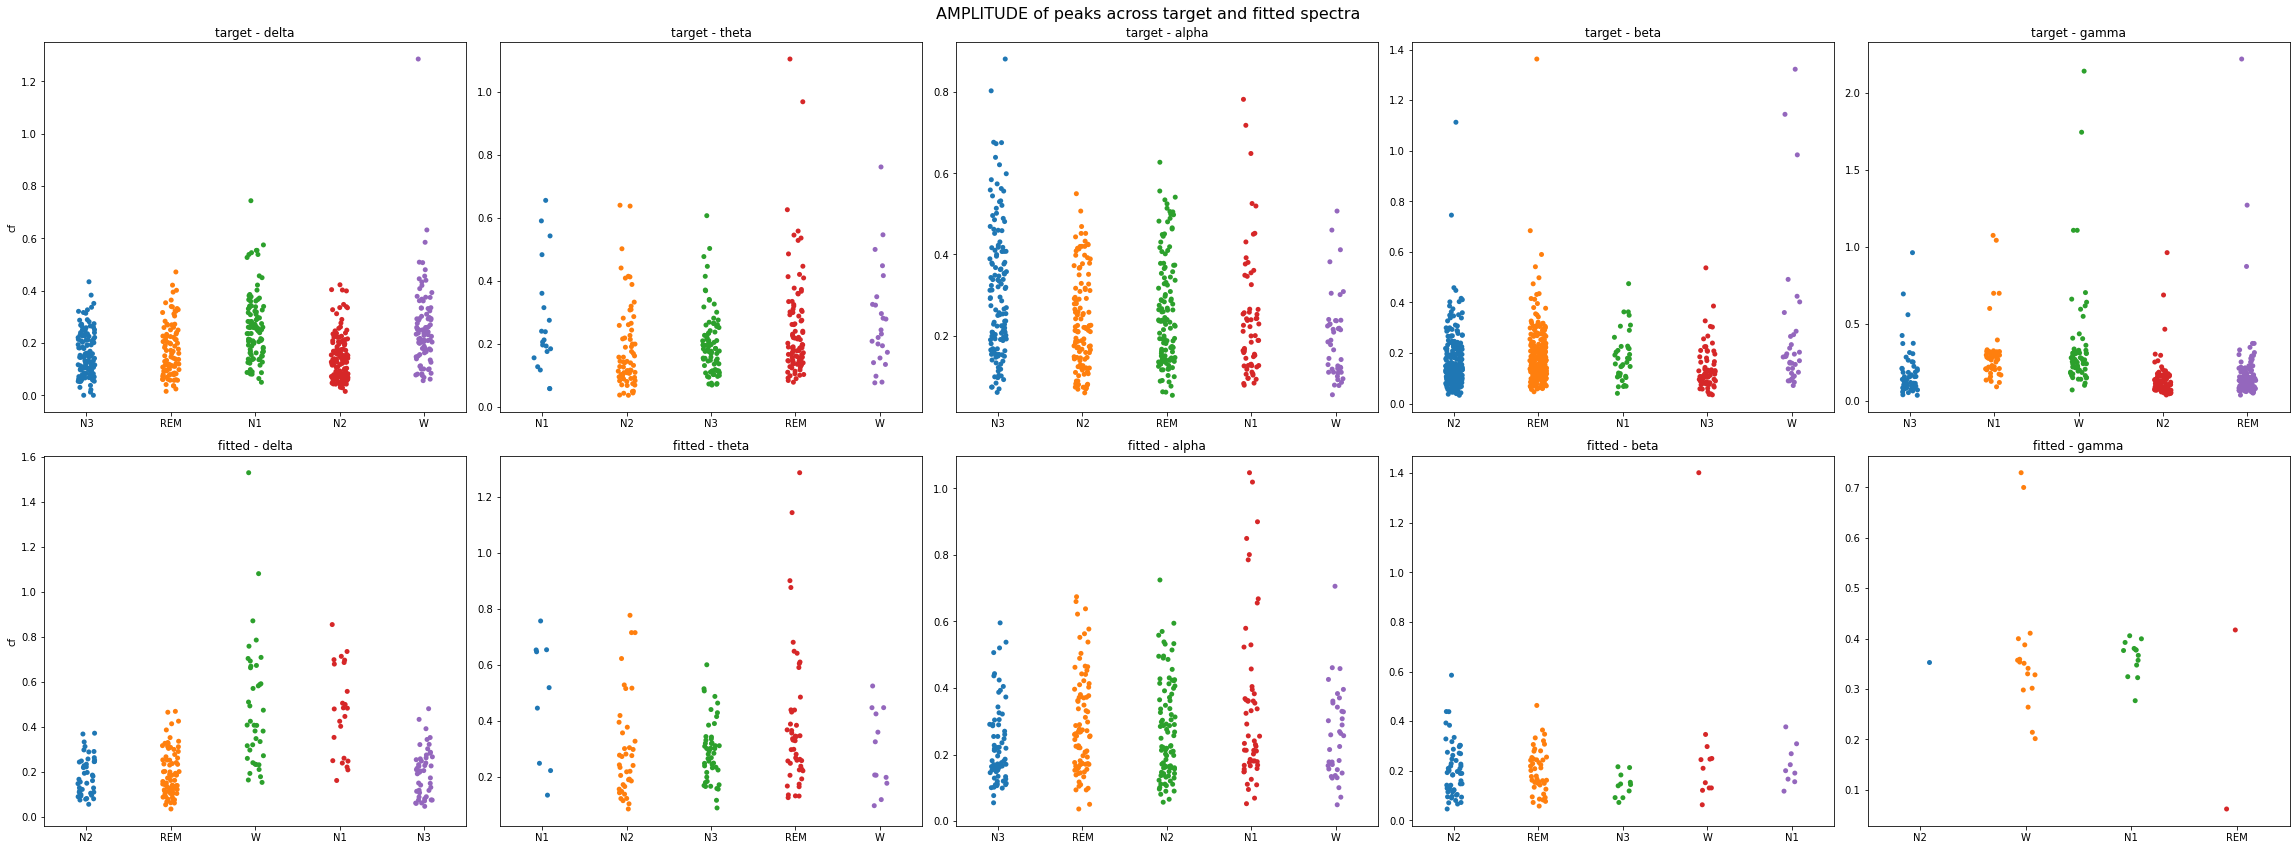

In [ ]:
fig,axes=plt.subplots(figsize=(32,12), nrows=2, ncols=5);

for m,n in enumerate(['target', 'fitted']):
    for i, (band, fband) in enumerate(bands.items()):
        ax = axes[m,i]
        a=df_fooof_params.loc[:,:,n].swaplevel(2,0).loc[n].swaplevel(2,0).reset_index()

        l_freq, h_freq = fband
        c=a[np.array(a['cf']<h_freq) * np.array(a['cf']>l_freq)]

        sns.stripplot(x='stages',
                    y='amp',
                    data=c,
                    ax=ax)#,
                    # kind='strip')
        ax.set(title=n + ' - ' + band,xlabel='', ylabel='')
axes[0,0].set(ylabel='cf')
axes[1,0].set(ylabel='cf')
plt.suptitle('AMPLITUDE of peaks across target and fitted spectra', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
stages

array(['N1', 'N2', 'N3', 'REM', 'W'], dtype=object)

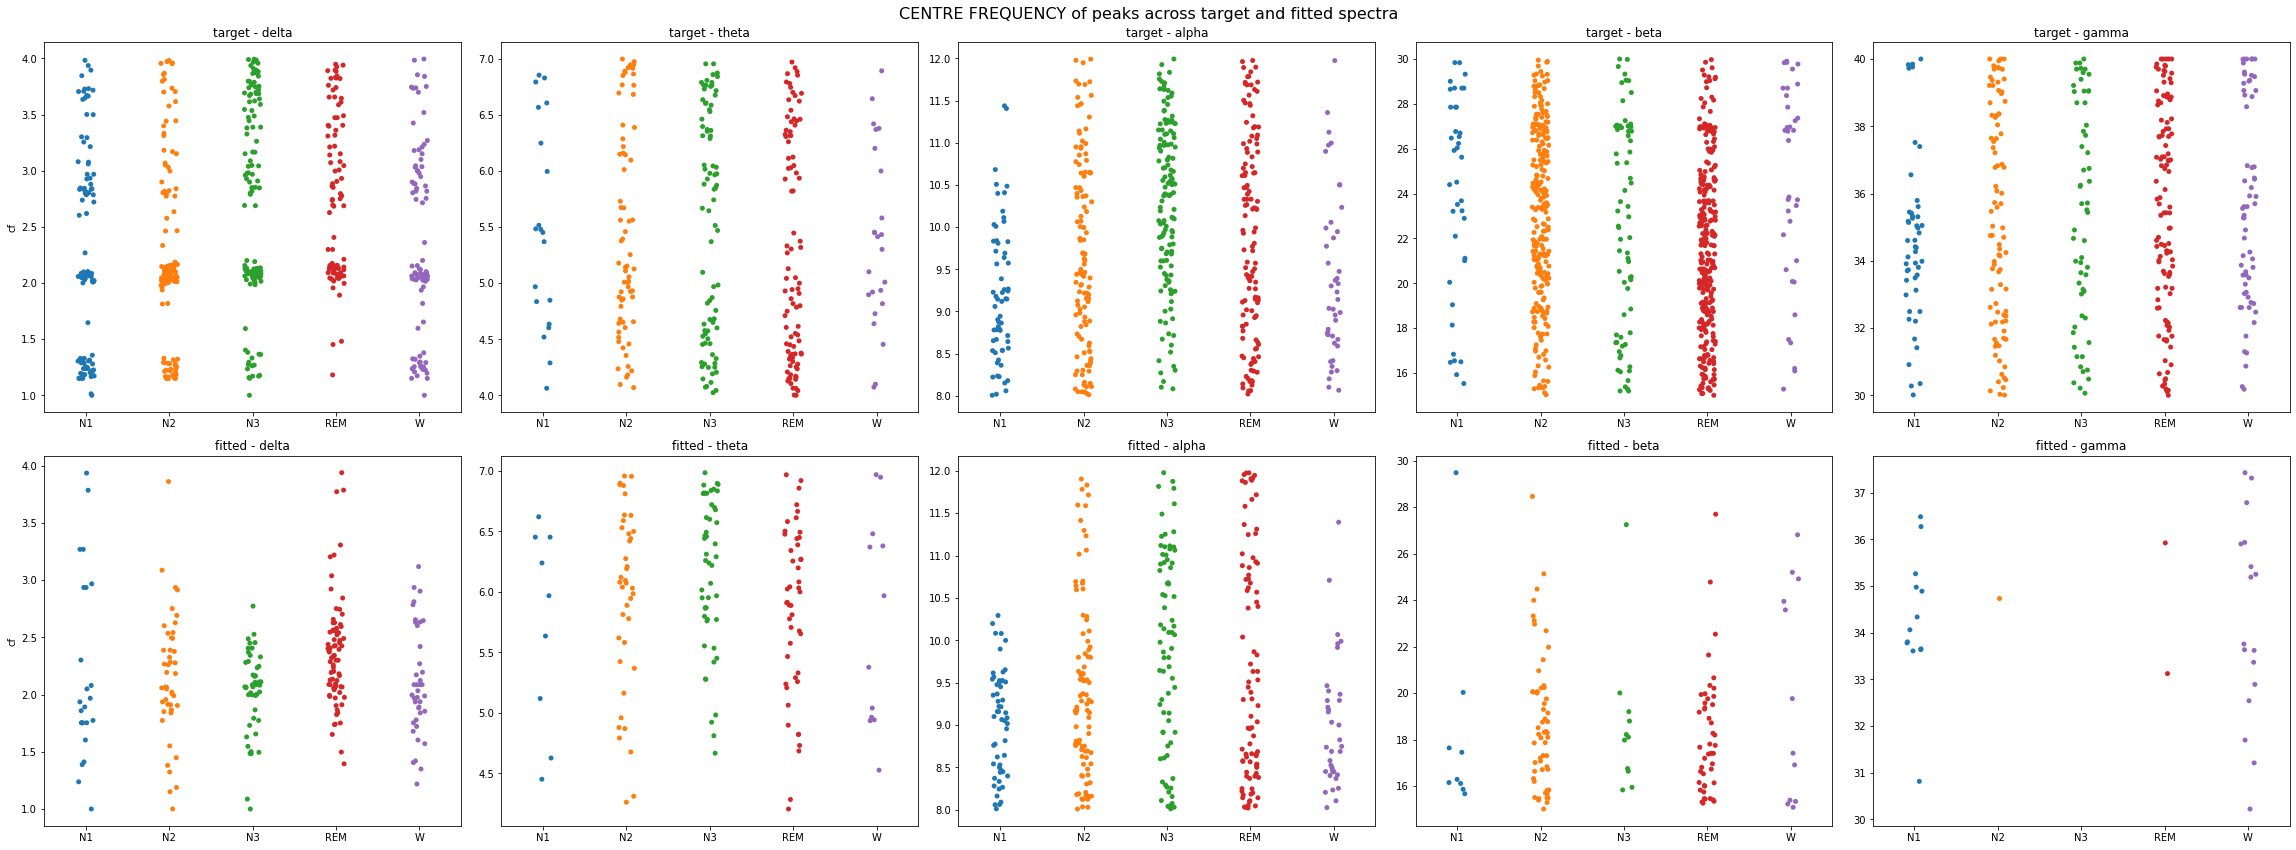

In [ ]:
fig,axes=plt.subplots(figsize=(32,12), nrows=2, ncols=5);

for m,n in enumerate(['target', 'fitted']):
    for i, (band, fband) in enumerate(bands.items()):
        ax = axes[m,i]
        a=df_fooof_params.loc[:,:,n].swaplevel(2,0).loc[n].swaplevel(2,0).reset_index()

        l_freq, h_freq = fband
        c=a[np.array(a['cf']<h_freq) * np.array(a['cf']>l_freq)]
        sns.stripplot(x='stages',
                    y='cf',
                    data=c,
                    order=stages,
                    ax=ax)#,
                    # kind='strip')
        ax.set(title=n + ' - ' + band,xlabel='', ylabel='')
axes[0,0].set(ylabel='cf')
axes[1,0].set(ylabel='cf')
plt.suptitle('CENTRE FREQUENCY of peaks across target and fitted spectra', fontsize=16)
plt.tight_layout()
plt.show()

Now let's see the difference in the amplitudes and CFs *after* we do the fitting:

In [ ]:
df_fooof_params.swaplevel(2,0).loc['fitted'].reset_index()

stages  sids         cf       amp        bw
0        N1     0   5.634690  0.653471  6.969279
1        N2     0   4.792373  0.190749  1.650678
2        N2     0   7.471844  0.608449  2.390338
3        N3     0   5.419971  0.301890  3.300789
4        N3     0  10.167004  0.153479  5.589483
...     ...   ...        ...       ...       ...
1167    REM   147  12.778172  0.267342  5.190582
1168    REM   147  17.749570  0.152734  3.414765
1169      W   147   1.891521  0.298235  1.839779
1170      W   147   8.027566  0.177578  2.331112
1171      W   147   9.364166  0.354812  1.670288

[1172 rows x 5 columns]